
# Provider Segmentation via Clustering — Training Workbook

Two parts per step: **Theory** and **Practice**.  

## Pipeline
1) Config  
2) Setup  
3) Data load (mock with numeric + categorical, or external)  
4) Feature mapping (with optional one-hot encoding)  
5) EDA  
5.1) Feature visualization  
6) Missing values & casting  
7) Feature engineering  
8) Feature selection  
9) Outlier handling  
10) Scaling  
10.1) Compare clustering across two scalers  
11) PCA  
11.1) 3D PCA visualization  
12) Clustering models  
13) Hyperparameter sweeps  
14) Validation metrics  
15) Visualization (scatter + centroids)  
16) Cluster profiling  
16.1) Cluster characteristic visualization  
16.2) Cluster naming (business interpretation)  
17) Export artifacts  
18) Exercises



## 1) Config

Centralize all knobs for data, preprocessing, and algorithms. Edit here, then run top-to-bottom.


In [1]:

# 1) Config — Practice

# Reproducibility
RANDOM_STATE = 42

# Data
USE_MOCK = True # False if use real data
N_SAMPLES = 500 # Change here

# External data (if USE_MOCK=False)
READ_FROM = "csv"       # "csv", "parquet"
DATA_PATH = "providers.csv"

# Categorical handling
ENCODE_CATEGORICAL = True  # one-hot encode non-numeric categoricals

# Clustering algorithm
ALGO = "kmeans"         # "kmeans", "gmm", "agglo", "dbscan", "spectral"

# Scaling
SCALER = "standard"     # "standard", "minmax", "robust"

# PCA
APPLY_PCA = True
PCA_N_COMPONENTS = 3    # set >=3 to enable 3D plot

# Outlier handling
OUTLIER_METHOD = "zscore"  # "none", "zscore", "iqr"
Z_MAX = 4.0
IQR_MULT = 3.0

# Feature selection
FEATURE_SELECTION_METHOD = "none"  # "variance", "correlation", "univariate", "model", "none"
VARIANCE_MIN = 0.01
CORR_MAX = 0.90
TOP_K = 8
MODEL_TYPE = "rf"        # "rf" or "lasso"
UNIVARIATE_SCORE = "f"   # "f" or "chi2"

# Hyperparameter sweeps
DO_SWEEP = True
K_RANGE = list(range(2, 13))
GMM_RANGE = list(range(2, 13))
DBSCAN_EPS_GRID = [0.3, 0.5, 0.7, 1.0, 1.5]
DBSCAN_MIN_SAMPLES_GRID = [5, 10, 20]



## 2) Setup

Import core libraries and set seed for reproducibility.


In [2]:

# 2) Setup — Practice

import os, warnings, json, math
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore")
np.random.seed(RANDOM_STATE)

print("Setup complete.")


Setup complete.



## 3) Data Load

Generate **mock data** including numeric KPIs and non-numeric columns, or load an external file.  
Categoricals/datetimes are included for realism. We encode categoricals later if enabled.


In [3]:

# 3) Data Load — Practice

if USE_MOCK:
    df = pd.DataFrame({
        "professional_id": np.arange(1, N_SAMPLES+1),
        # numeric KPIs
        "total_bookings": np.random.poisson(lam=50, size=N_SAMPLES),
        "avg_rating": np.random.normal(4.5, 0.3, size=N_SAMPLES).clip(1,5),
        "total_income": np.random.gamma(5, 200, size=N_SAMPLES),
        "total_work_hour": np.random.randint(50, 300, size=N_SAMPLES),
        "avg_booking_per_month": np.random.poisson(5, size=N_SAMPLES),
        "avg_income_per_month": np.random.gamma(2, 100, size=N_SAMPLES),
        "avg_work_hour_per_month": np.random.randint(20, 100, size=N_SAMPLES),
        "latest_month_booking": np.random.poisson(5, size=N_SAMPLES),
        "latest_month_rating": np.random.normal(4.4, 0.4, size=N_SAMPLES).clip(1,5),
        "latest_diff_avg_booking": np.random.normal(0, 2, size=N_SAMPLES),
        "booking_ratio_latest_to_previous": np.random.uniform(0.5, 1.5, size=N_SAMPLES),
        "work_hour_ratio_latest_to_previous": np.random.uniform(0.5, 1.5, size=N_SAMPLES),
        "total_active_days": np.random.randint(30, 1000, size=N_SAMPLES),
        "active_months_ratio": np.random.uniform(0.1, 1.0, size=N_SAMPLES),
        "booking_std": np.random.uniform(1, 10, size=N_SAMPLES),
        "rating_std": np.random.uniform(0.1, 0.5, size=N_SAMPLES),
        "work_hour_std": np.random.uniform(5, 20, size=N_SAMPLES),
        "income_std": np.random.uniform(50, 200, size=N_SAMPLES),
        "tenures": np.random.randint(1, 60, size=N_SAMPLES),
        # non-numeric
        "province": np.random.choice(["Bangkok", "Chiang Mai", "Khon Kaen", "Phuket"], size=N_SAMPLES),
        "training_center": np.random.choice(["A", "B", "C"], size=N_SAMPLES),
        "join_date": pd.to_datetime("2024-01-01") + pd.to_timedelta(np.random.randint(0, 1500, size=N_SAMPLES), unit="D"),
        "gender": np.random.choice(["Male", "Female"], size=N_SAMPLES)
    })
else:
    if READ_FROM == "csv":
        df = pd.read_csv(DATA_PATH, encoding="utf-8", low_memory=False)
    elif READ_FROM == "parquet":
        df = pd.read_parquet(DATA_PATH)
    else:
        raise ValueError("Unsupported READ_FROM")

print("Data shape:", df.shape)
display(df.head(5))


Data shape: (500, 24)


,professional_id,total_bookings,avg_rating,total_income,total_work_hour,avg_booking_per_month,avg_income_per_month,avg_work_hour_per_month,latest_month_booking,latest_month_rating,...,active_months_ratio,booking_std,rating_std,work_hour_std,income_std,tenures,province,training_center,join_date,gender
0,1,47,4.475355,1199.601633,257,2,328.441790,71,2,4.711675,...,0.445870,9.816525,0.176180,14.983346,100.560704,46,Phuket,C,2027-11-30,Female
1,2,55,4.835189,360.564319,121,5,43.384858,86,6,4.663736,...,0.149808,9.823524,0.493037,14.709807,54.690707,53,Chiang Mai,A,2026-10-10,Male
2,3,42,4.602818,1608.824375,173,9,177.590644,63,7,4.740870,...,0.828884,4.403272,0.423076,8.695570,72.817460,13,Khon Kaen,B,2027-11-01,Female
3,4,52,4.637026,1255.438527,274,7,89.226878,51,3,4.401964,...,0.985758,1.229715,0.383932,10.922854,71.282774,44,Khon Kaen,A,2027-03-21,Female
4,5,58,4.670930,845.906365,162,5,88.243206,29,5,4.813744,...,0.841626,7.545382,0.370864,15.249555,198.291576,24,Phuket,C,2027-09-07,Female


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   professional_id                     500 non-null    int64         
 1   total_bookings                      500 non-null    int32         
 2   avg_rating                          500 non-null    float64       
 3   total_income                        500 non-null    float64       
 4   total_work_hour                     500 non-null    int32         
 5   avg_booking_per_month               500 non-null    int32         
 6   avg_income_per_month                500 non-null    float64       
 7   avg_work_hour_per_month             500 non-null    int32         
 8   latest_month_booking                500 non-null    int32         
 9   latest_month_rating                 500 non-null    float64       
 10  latest_diff_avg_booking   


## 4) Feature Mapping

Choose the **ID** and the **numeric feature set** for clustering.  
Optionally **one-hot encode** categoricals to include them.


In [6]:

# 4) Feature Mapping — Practice

ID_COL = "professional_id"

CANDIDATE_NUMERIC = [
    "total_bookings", "avg_rating", "total_income", "total_work_hour",
    "avg_booking_per_month", "avg_income_per_month", "avg_work_hour_per_month",
    "latest_month_booking", "latest_month_rating", "latest_diff_avg_booking",
    "booking_ratio_latest_to_previous", "work_hour_ratio_latest_to_previous",
    "total_active_days", "active_months_ratio",
    "booking_std", "rating_std", "work_hour_std", "income_std", "tenures"
]

FEATURES = [c for c in CANDIDATE_NUMERIC if c in df.columns]
NON_NUMERIC = [c for c in df.columns if c not in [ID_COL] + FEATURES]

if ENCODE_CATEGORICAL:
    cat_cols = [c for c in NON_NUMERIC if df[c].dtype == "object" or str(df[c].dtype).startswith("category")]
    try:
        encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore")
    except TypeError:
        encoder = OneHotEncoder(sparse=False, drop=None, handle_unknown="ignore")
    cat_encoded = encoder.fit_transform(df[cat_cols]) if cat_cols else np.empty((len(df),0))
    cat_feature_names = encoder.get_feature_names_out(cat_cols) if cat_cols else []
    df_cat = pd.DataFrame(cat_encoded, columns=cat_feature_names, index=df.index) if cat_cols else pd.DataFrame(index=df.index)
    work = pd.concat([df[[ID_COL] + FEATURES], df_cat], axis=1)
    FEATURES = FEATURES + list(cat_feature_names)
else:
    work = df[[ID_COL] + FEATURES].copy()

print("Numeric base features:", FEATURES[:len(CANDIDATE_NUMERIC)])
extra = [f for f in FEATURES if f not in CANDIDATE_NUMERIC]
print("Encoded categorical features:", extra)
print("Final features used for clustering:", FEATURES)
display(work.head(3))


Numeric base features: ['total_bookings', 'avg_rating', 'total_income', 'total_work_hour', 'avg_booking_per_month', 'avg_income_per_month', 'avg_work_hour_per_month', 'latest_month_booking', 'latest_month_rating', 'latest_diff_avg_booking', 'booking_ratio_latest_to_previous', 'work_hour_ratio_latest_to_previous', 'total_active_days', 'active_months_ratio', 'booking_std', 'rating_std', 'work_hour_std', 'income_std', 'tenures']
Encoded categorical features: ['province_Bangkok', 'province_Chiang Mai', 'province_Khon Kaen', 'province_Phuket', 'training_center_A', 'training_center_B', 'training_center_C', 'gender_Female', 'gender_Male']
Final features used for clustering: ['total_bookings', 'avg_rating', 'total_income', 'total_work_hour', 'avg_booking_per_month', 'avg_income_per_month', 'avg_work_hour_per_month', 'latest_month_booking', 'latest_month_rating', 'latest_diff_avg_booking', 'booking_ratio_latest_to_previous', 'work_hour_ratio_latest_to_previous', 'total_active_days', 'active_mon

,professional_id,total_bookings,avg_rating,total_income,total_work_hour,avg_booking_per_month,avg_income_per_month,avg_work_hour_per_month,latest_month_booking,latest_month_rating,...,tenures,province_Bangkok,province_Chiang Mai,province_Khon Kaen,province_Phuket,training_center_A,training_center_B,training_center_C,gender_Female,gender_Male
0,1,47,4.475355,1199.601633,257,2,328.441790,71,2,4.711675,...,46,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,2,55,4.835189,360.564319,121,5,43.384858,86,6,4.663736,...,53,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,3,42,4.602818,1608.824375,173,9,177.590644,63,7,4.740870,...,13,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0



## 5) EDA

Check ID uniqueness, missingness, and descriptive stats to spot issues early.


In [7]:

# 5) EDA — Practice

print("Rows:", len(work), "| Unique IDs:", work[ID_COL].nunique(), "| Duplicate IDs:", work[ID_COL].duplicated().sum())

na_summary = work[[c for c in FEATURES]].isna().mean().sort_values(ascending=False).to_frame("missing_rate")
display(na_summary.head(10))

basic_stats = work[[c for c in FEATURES if c in work.columns]].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
display(basic_stats)


Rows: 500 | Unique IDs: 500 | Duplicate IDs: 0


,missing_rate
total_bookings,0.0
avg_rating,0.0
gender_Female,0.0
training_center_C,0.0
training_center_B,0.0
training_center_A,0.0
province_Phuket,0.0
province_Khon Kaen,0.0
province_Chiang Mai,0.0
province_Bangkok,0.0


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
total_bookings,500.0,49.644000,7.312195,29.000000,33.000000,38.000000,44.750000,50.000000,54.000000,62.000000,66.000000,69.000000
avg_rating,500.0,4.519873,0.287705,3.631123,3.772610,4.032817,4.318001,4.527905,4.719960,5.000000,5.000000,5.000000
total_income,500.0,1013.436619,435.254583,142.184963,266.371279,398.126022,686.422214,961.406676,1258.108833,1818.002474,2158.555824,2558.753320
total_work_hour,500.0,172.286000,69.969305,51.000000,53.990000,66.950000,111.000000,172.000000,227.000000,288.000000,297.000000,299.000000
avg_booking_per_month,500.0,5.010000,2.181609,0.000000,1.000000,2.000000,3.000000,5.000000,6.000000,9.000000,11.000000,11.000000
avg_income_per_month,500.0,194.007605,139.555300,8.524922,16.686254,37.799280,95.186059,160.434301,263.323156,480.281386,667.503561,861.814570
avg_work_hour_per_month,500.0,60.854000,23.317291,20.000000,20.000000,23.000000,41.000000,62.000000,81.000000,96.000000,99.000000,99.000000
latest_month_booking,500.0,4.930000,2.207906,0.000000,0.000000,2.000000,3.000000,5.000000,6.000000,8.000000,11.000000,14.000000
latest_month_rating,500.0,4.405531,0.385422,3.143434,3.509078,3.723604,4.140518,4.429150,4.717522,5.000000,5.000000,5.000000
latest_diff_avg_booking,500.0,-0.057355,1.887334,-5.645270,-4.288014,-3.142344,-1.314077,-0.096446,1.191125,2.915691,4.184204,7.088130



## 5.1) Feature Visualization

Use separate figures to examine distribution shape and outliers.


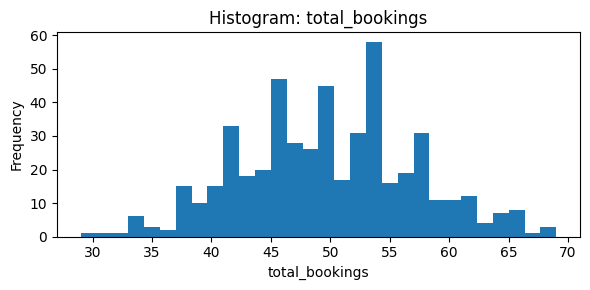

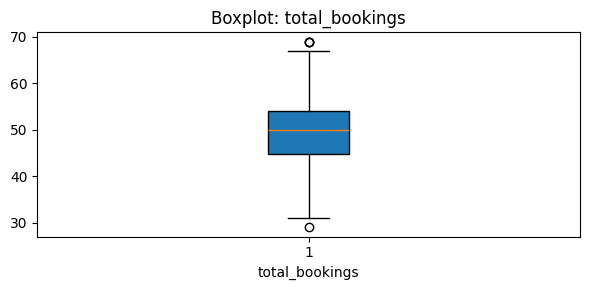

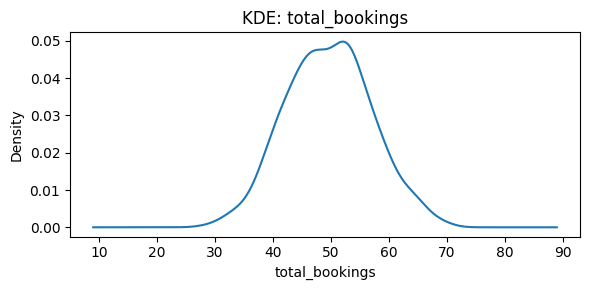

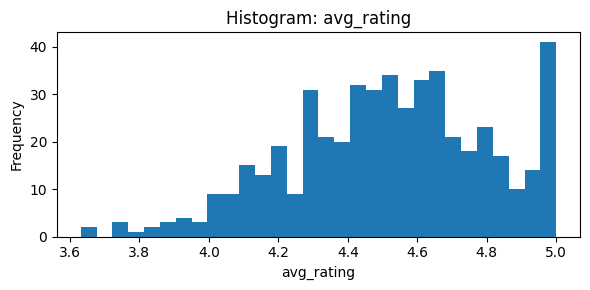

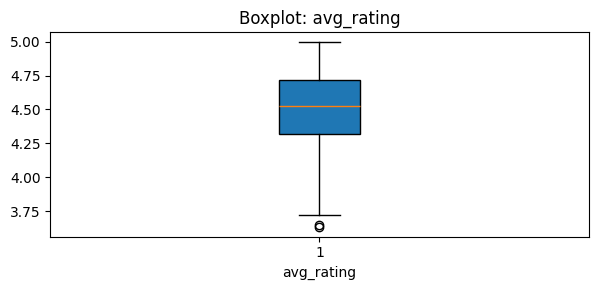

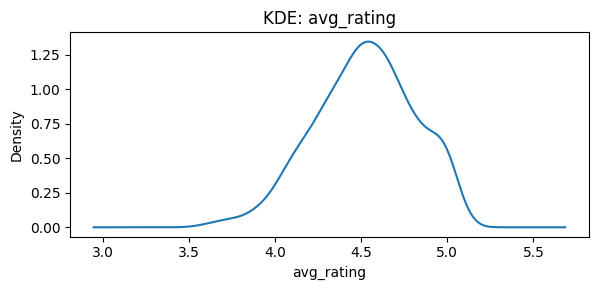

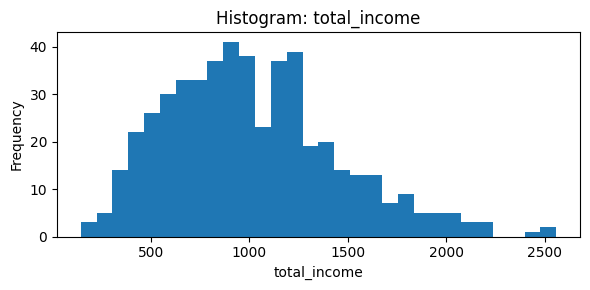

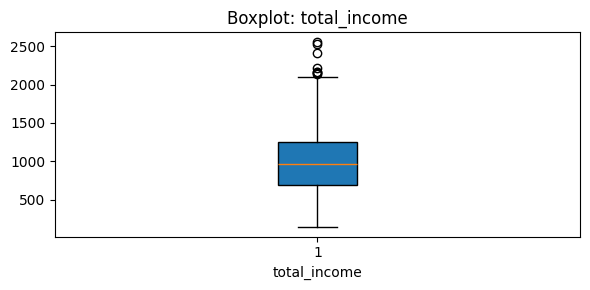

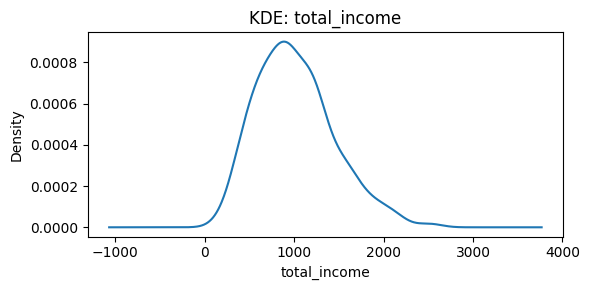

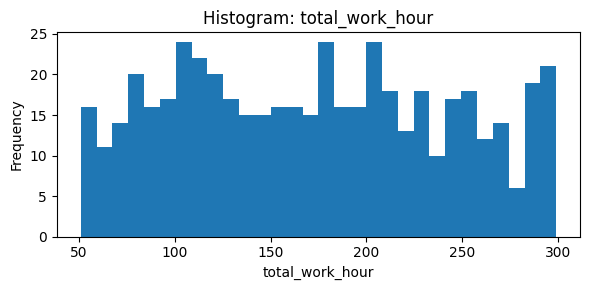

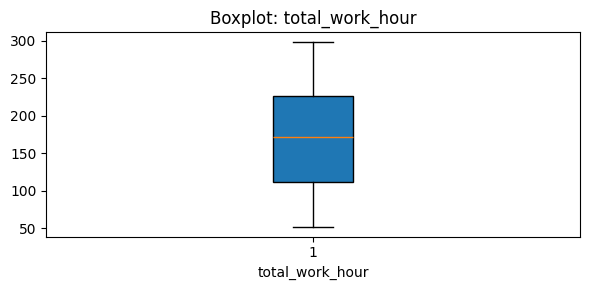

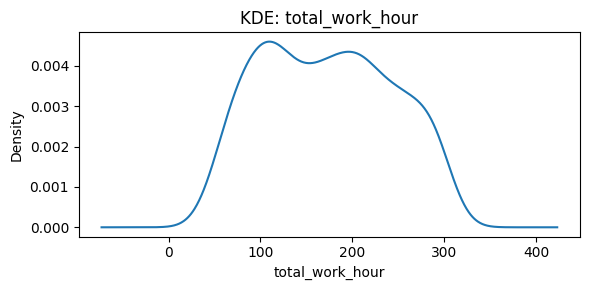

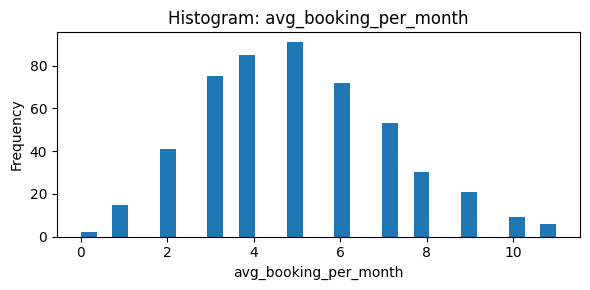

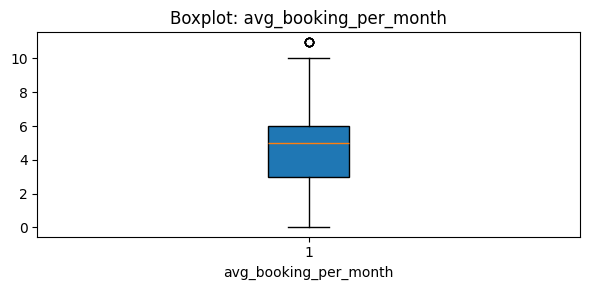

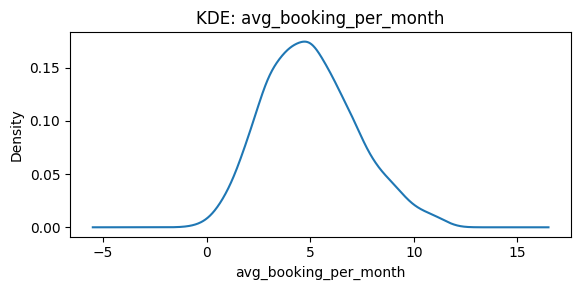

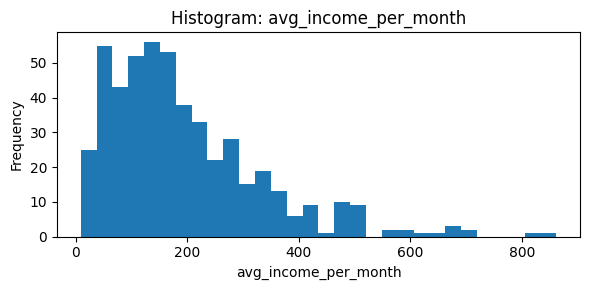

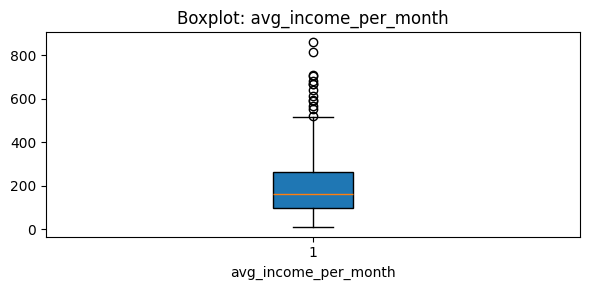

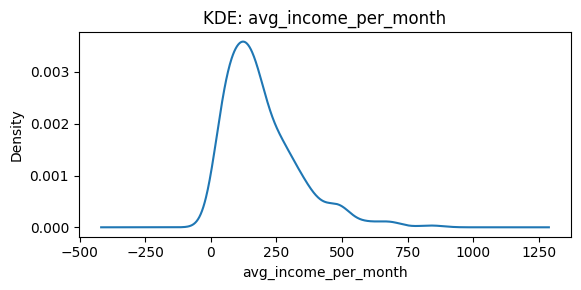

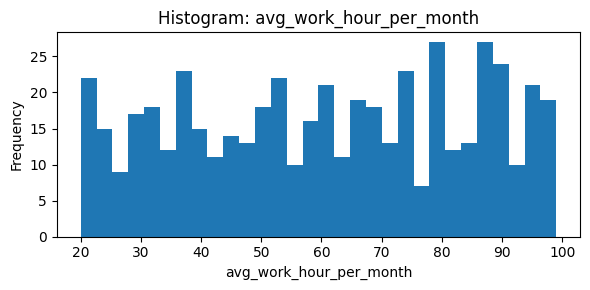

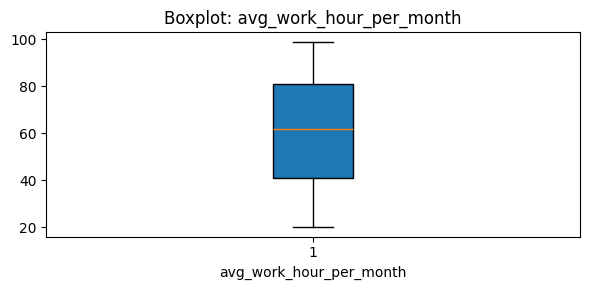

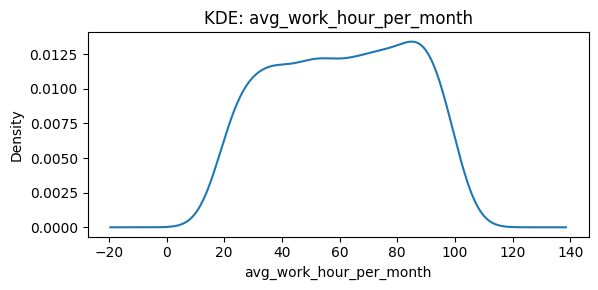

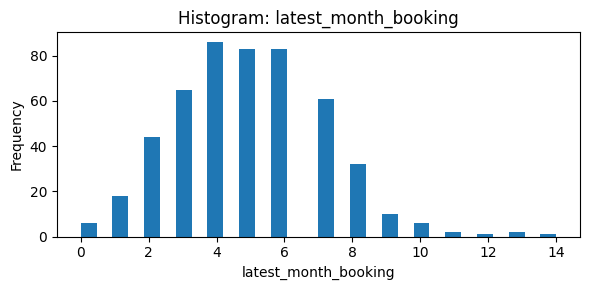

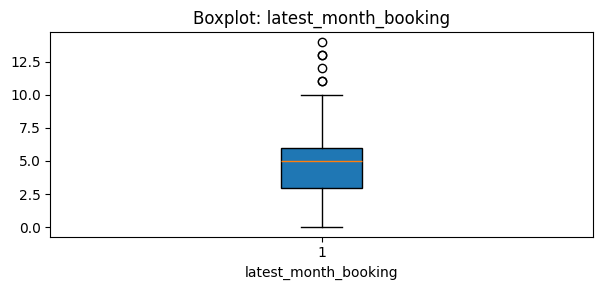

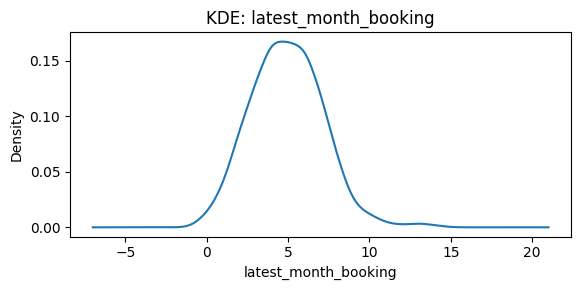

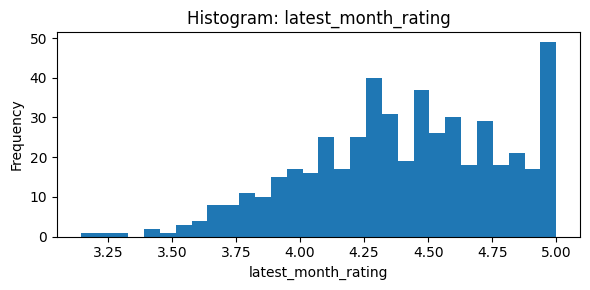

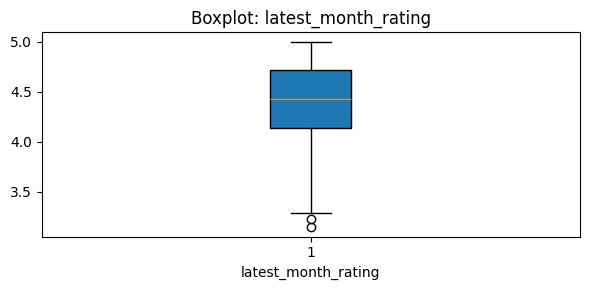

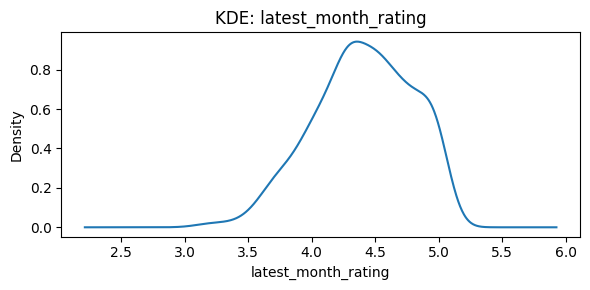

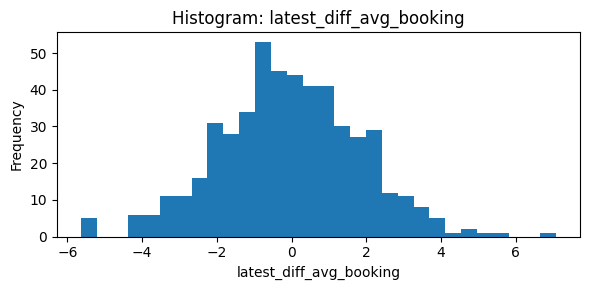

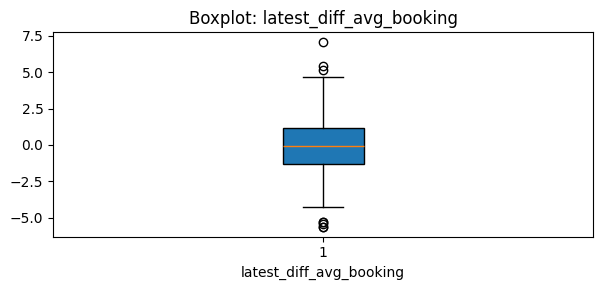

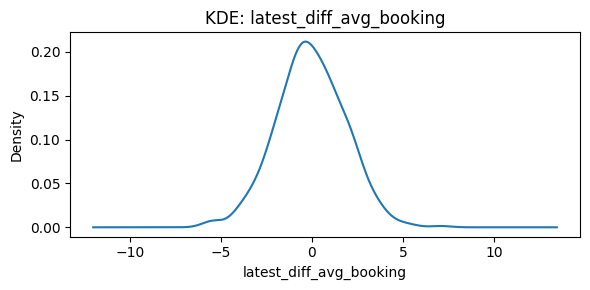

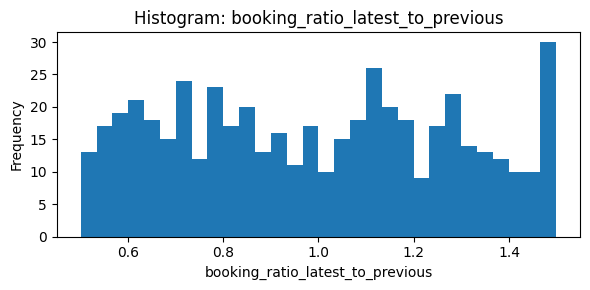

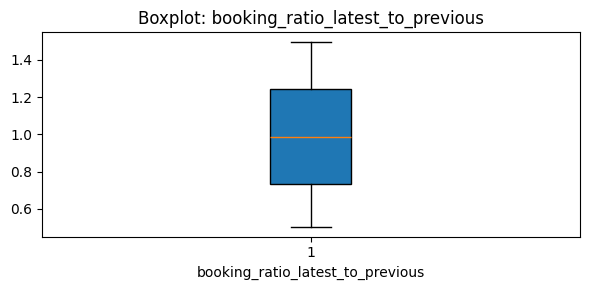

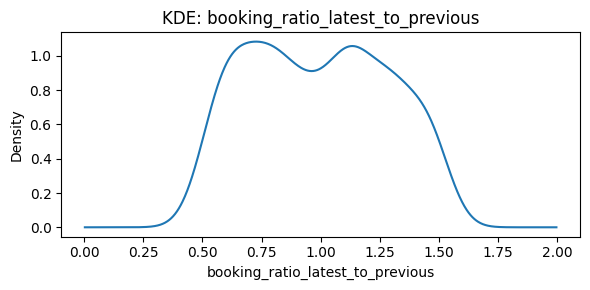

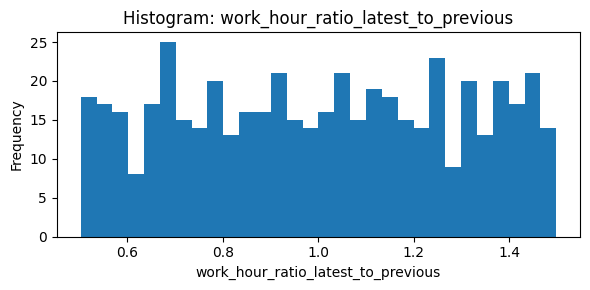

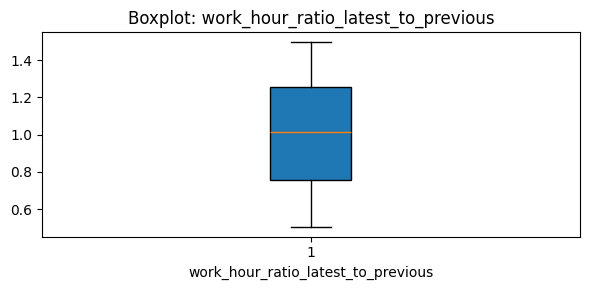

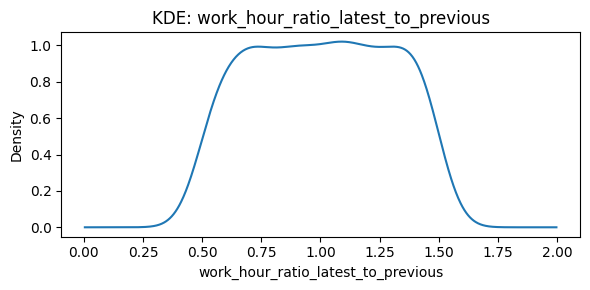

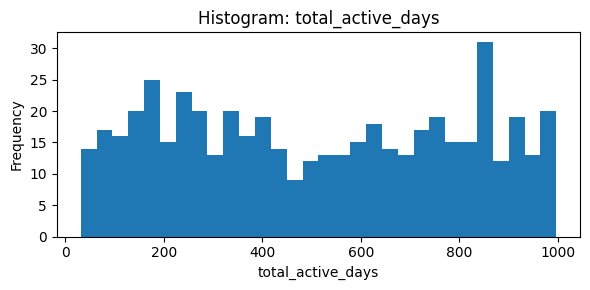

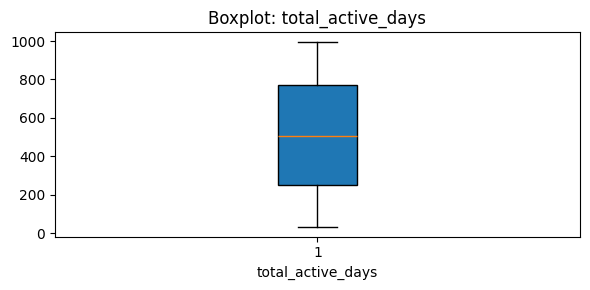

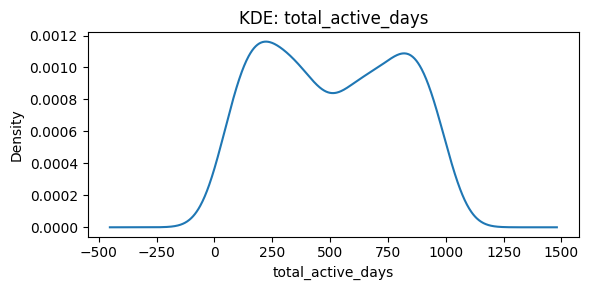

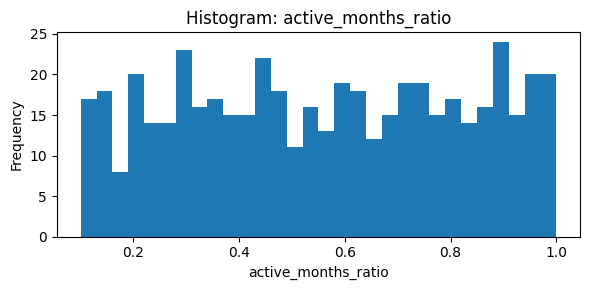

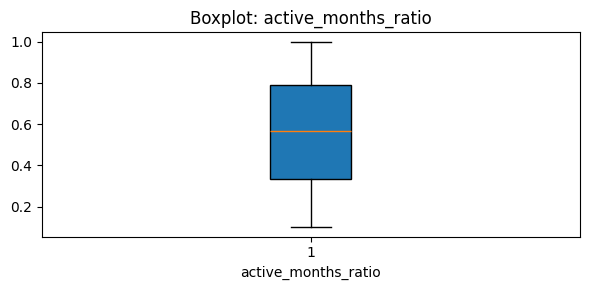

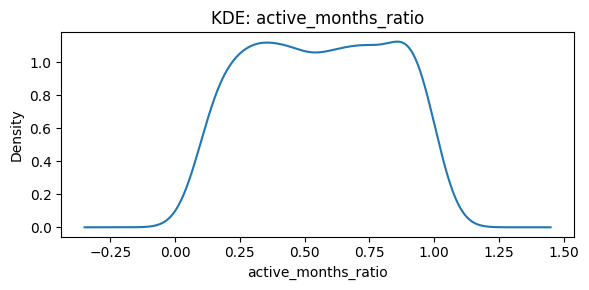

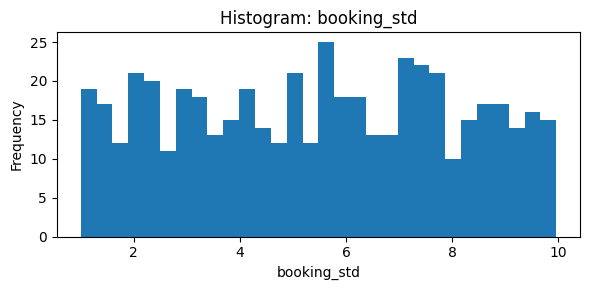

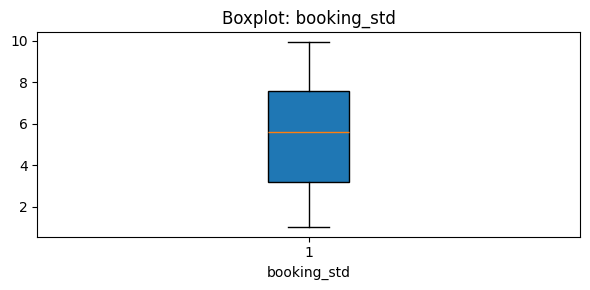

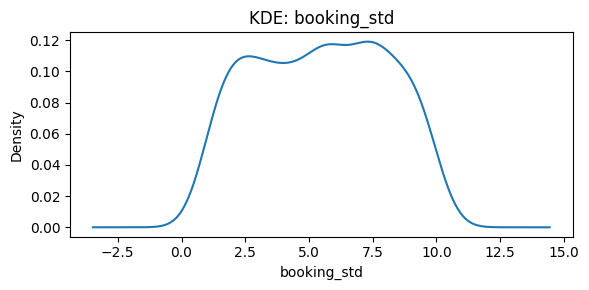

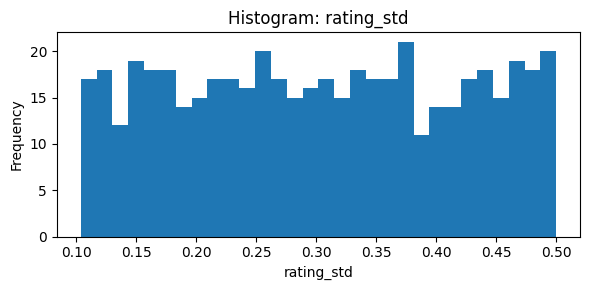

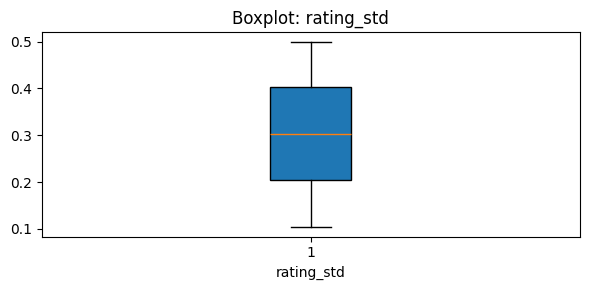

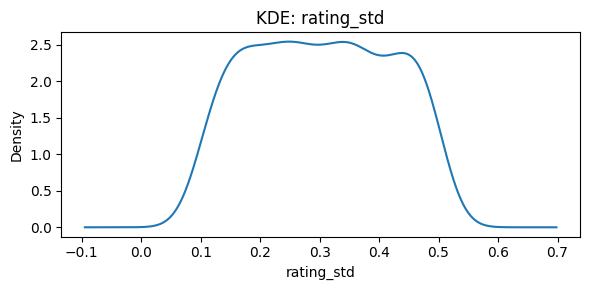

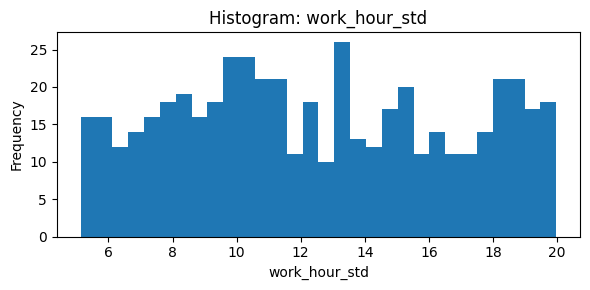

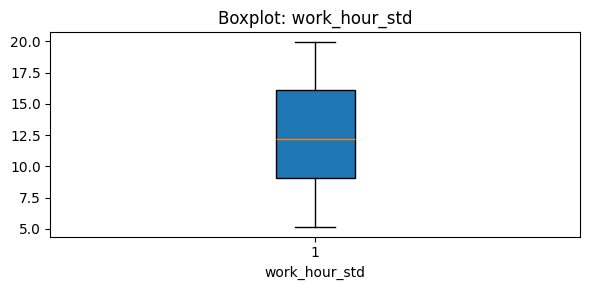

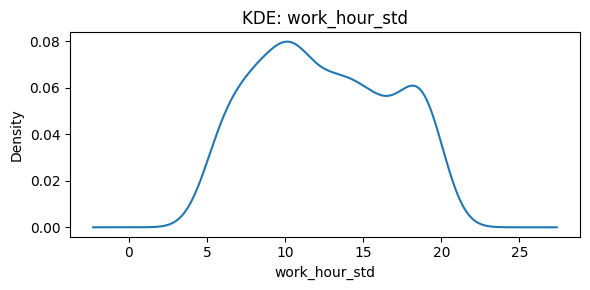

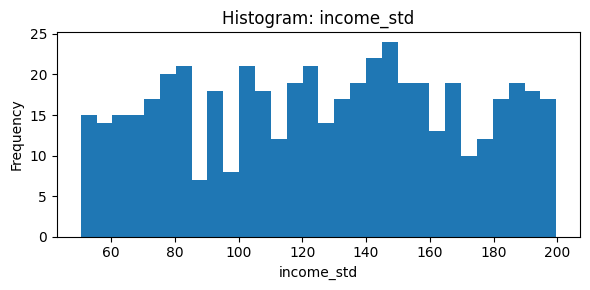

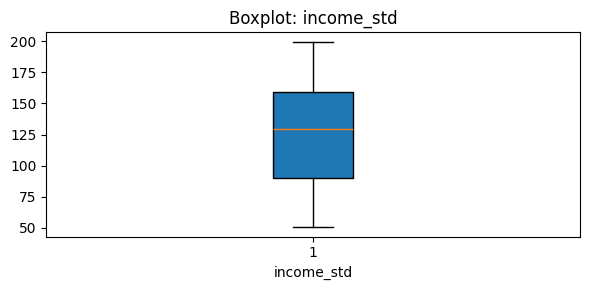

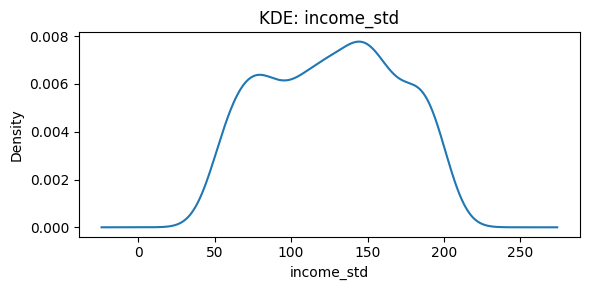

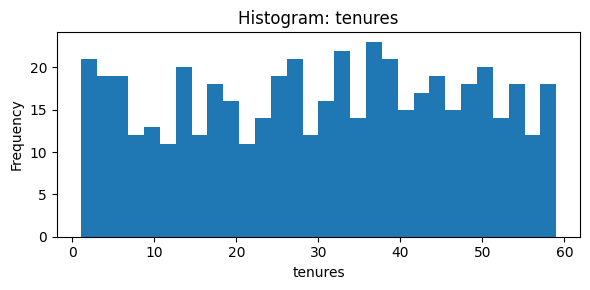

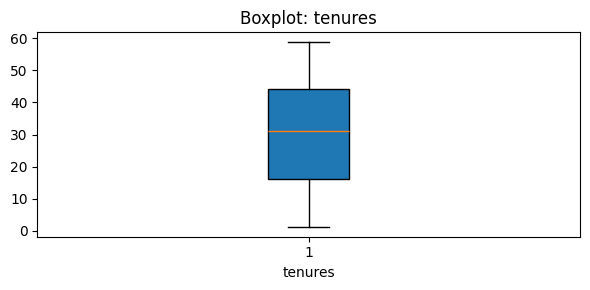

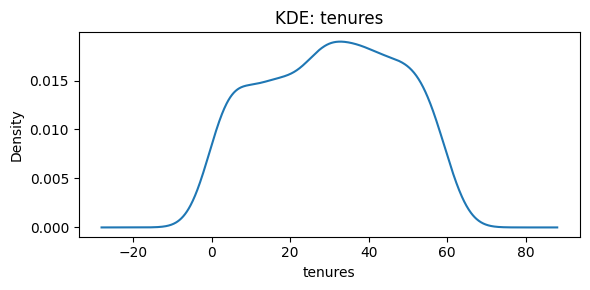

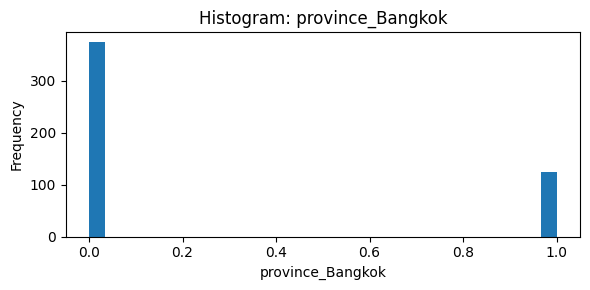

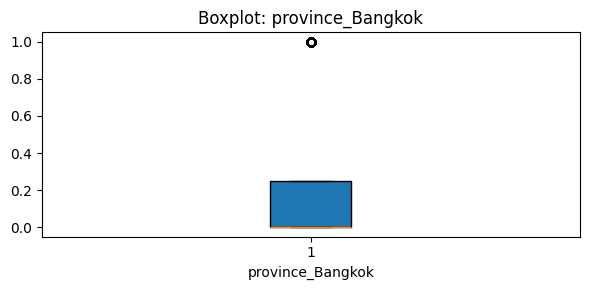

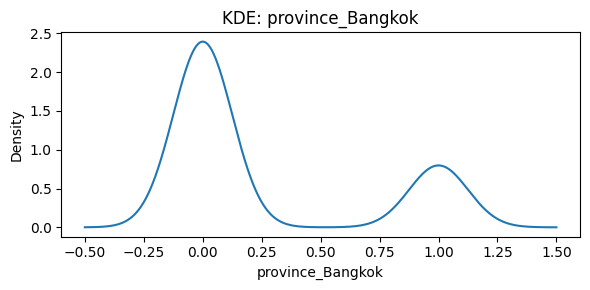

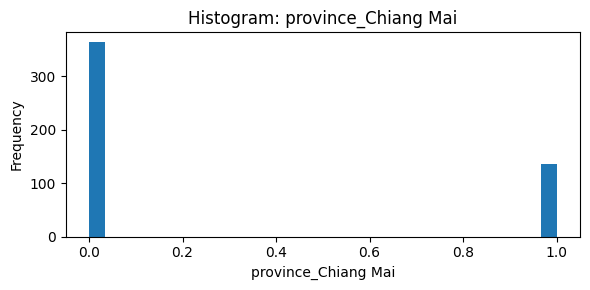

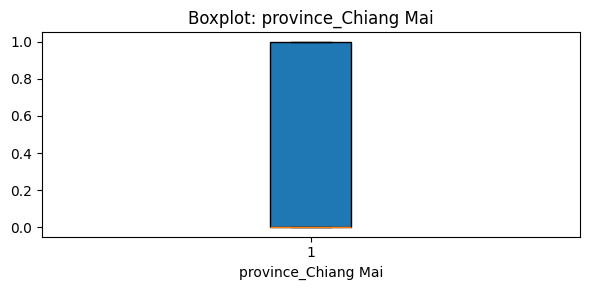

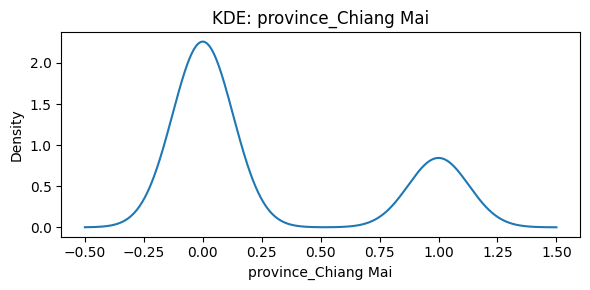

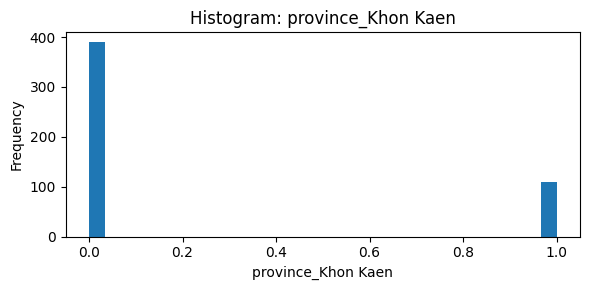

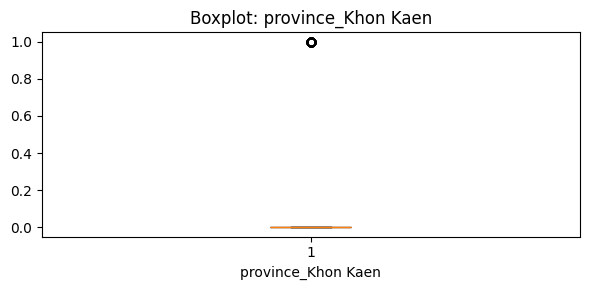

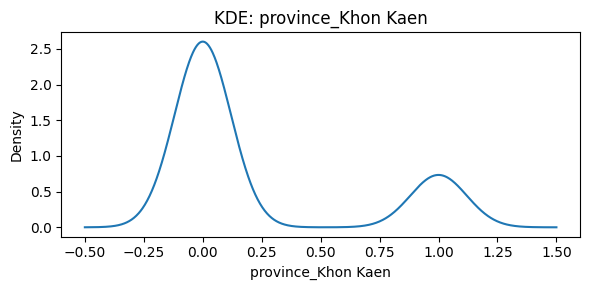

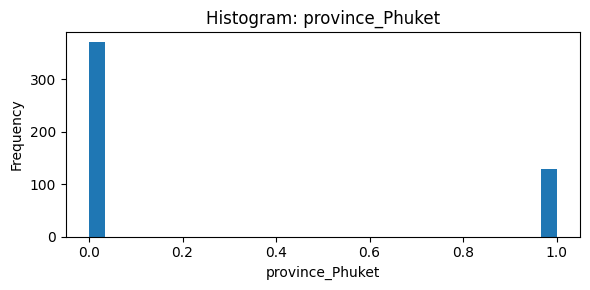

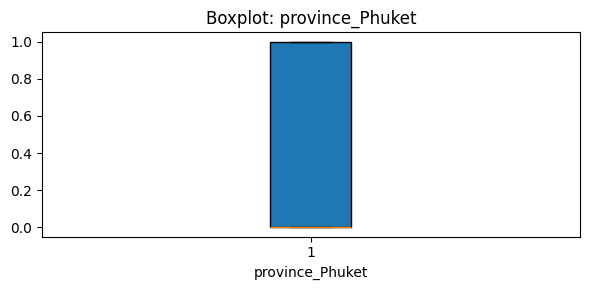

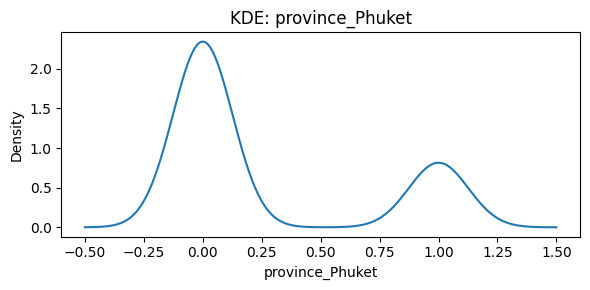

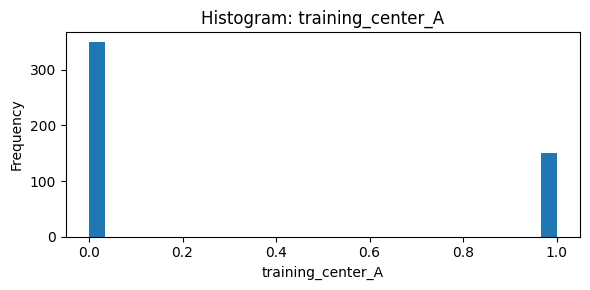

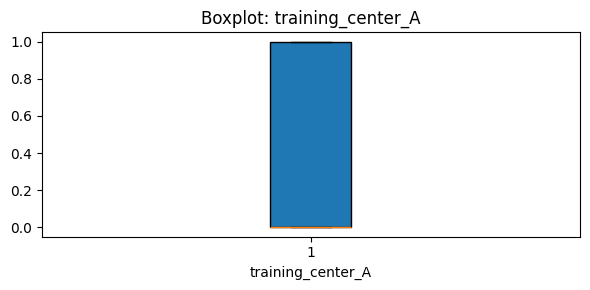

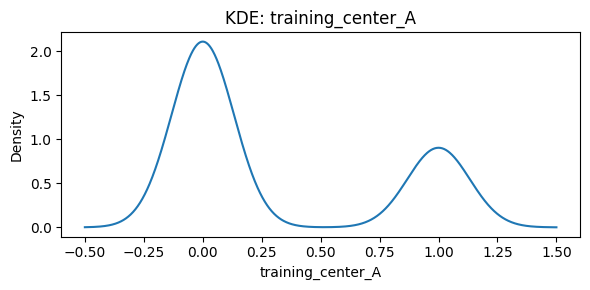

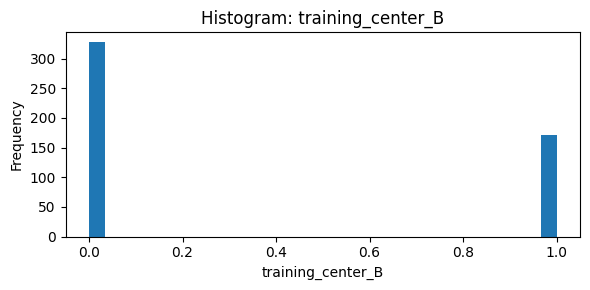

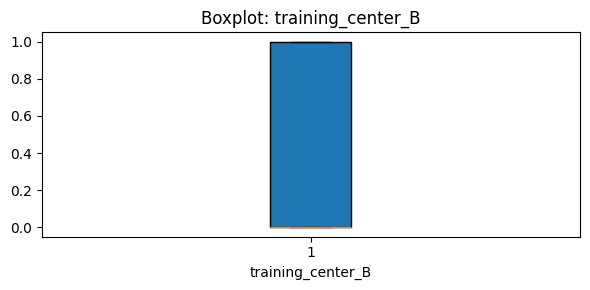

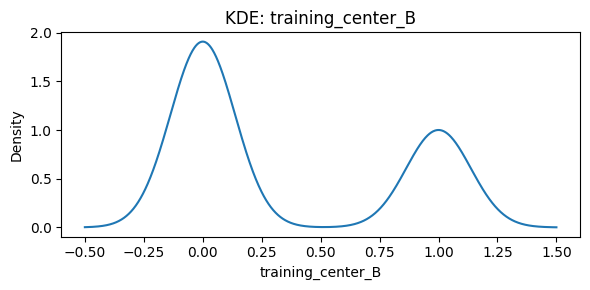

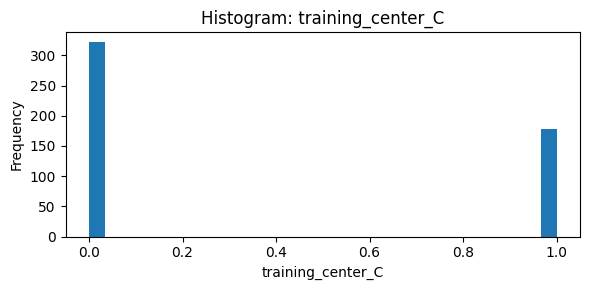

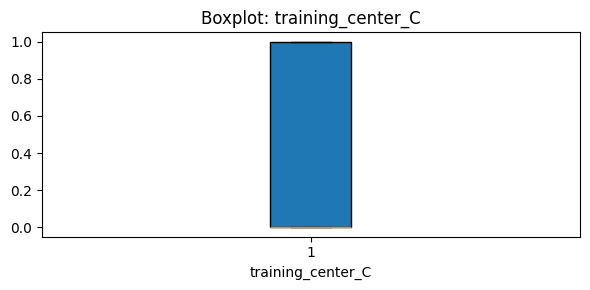

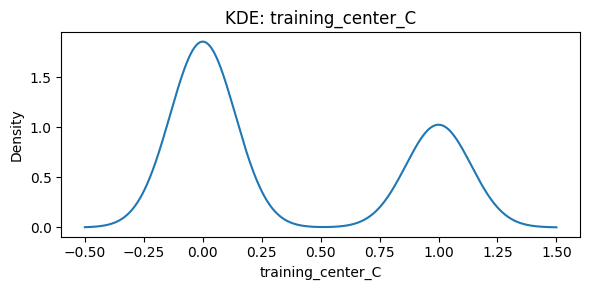

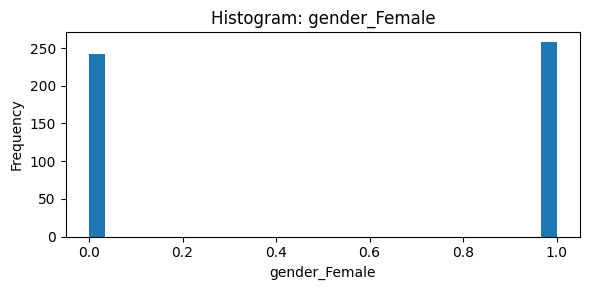

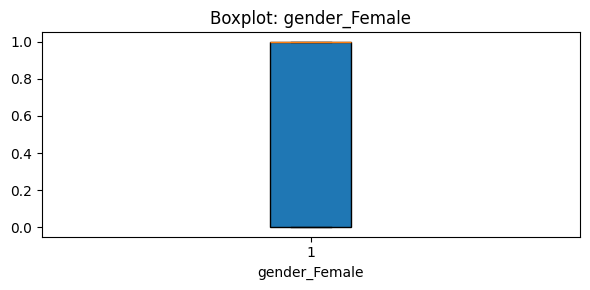

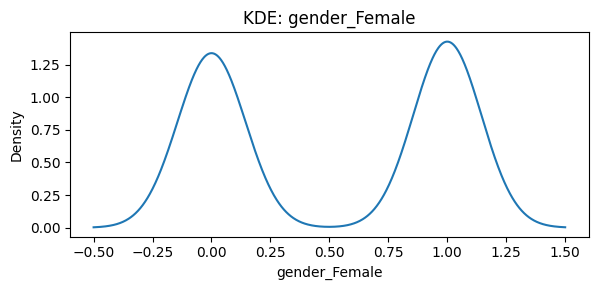

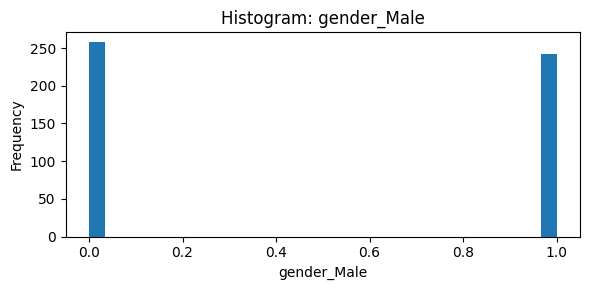

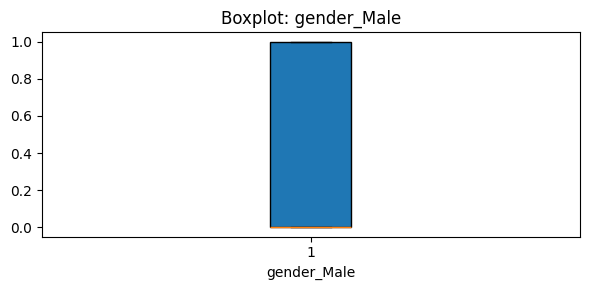

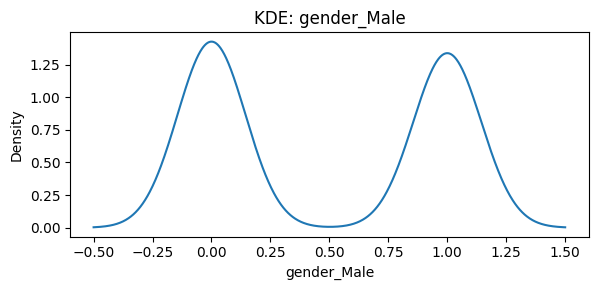

In [8]:

# 5.1) Feature Visualization — Practice

FEATURES_TO_PLOT = FEATURES  # or choose a subset for speed

for col in FEATURES_TO_PLOT:
    # Histogram
    plt.figure(figsize=(6,3))
    plt.hist(work[col].dropna(), bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()

    # Boxplot
    plt.figure(figsize=(6,3))
    plt.boxplot(work[col].dropna(), vert=True, patch_artist=True)
    plt.title(f"Boxplot: {col}")
    plt.xlabel(col)
    plt.tight_layout(); plt.show()

    # KDE
    plt.figure(figsize=(6,3))
    work[col].dropna().plot(kind="kde")
    plt.title(f"KDE: {col}")
    plt.xlabel(col)
    plt.tight_layout(); plt.show()



## 6) Missing Values & Casting — Theory

Impute numeric features.  
Mean imputation:  
$$
\hat{x}_j = \frac{1}{n}\sum_{i=1}^n x_{ij}
$$
Median imputation is robust to outliers. After imputation, cast to float for consistency.


In [ ]:

# 6) Missing Values & Casting — Practice

MAX_MISSING_COL_RATE = 0.5
NUMERIC_IMPUTE_STRATEGY = "median" # or mean
CAST_FLOAT64 = True

FEATURES = [c for c in FEATURES if work[c].isna().mean() <= MAX_MISSING_COL_RATE]

for c in FEATURES:
    work[c] = pd.to_numeric(work[c], errors="coerce")
    if NUMERIC_IMPUTE_STRATEGY == "mean":
        work[c] = work[c].fillna(work[c].mean())
    else:
        work[c] = work[c].fillna(work[c].median())
    if CAST_FLOAT64:
        work[c] = work[c].astype("float64")

print("Remaining features:", FEATURES)
display(work[FEATURES].head(3))


Remaining features: ['total_bookings', 'avg_rating', 'total_income', 'total_work_hour', 'avg_booking_per_month', 'avg_income_per_month', 'avg_work_hour_per_month', 'latest_month_booking', 'latest_month_rating', 'latest_diff_avg_booking', 'booking_ratio_latest_to_previous', 'work_hour_ratio_latest_to_previous', 'total_active_days', 'active_months_ratio', 'booking_std', 'rating_std', 'work_hour_std', 'income_std', 'tenures', 'province_Bangkok', 'province_Chiang Mai', 'province_Khon Kaen', 'province_Phuket', 'training_center_A', 'training_center_B', 'training_center_C', 'gender_Female', 'gender_Male']


,total_bookings,avg_rating,total_income,total_work_hour,avg_booking_per_month,avg_income_per_month,avg_work_hour_per_month,latest_month_booking,latest_month_rating,latest_diff_avg_booking,...,tenures,province_Bangkok,province_Chiang Mai,province_Khon Kaen,province_Phuket,training_center_A,training_center_B,training_center_C,gender_Female,gender_Male
0,47.0,4.475355,1199.601633,257.0,2.0,328.441790,71.0,2.0,4.711675,-2.773536,...,46.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,55.0,4.835189,360.564319,121.0,5.0,43.384858,86.0,6.0,4.663736,-0.223067,...,53.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,42.0,4.602818,1608.824375,173.0,9.0,177.590644,63.0,7.0,4.740870,0.344186,...,13.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0



## 7) Feature Engineering

Add domain KPIs carefully. Handle divide-by-zero and missing values.


In [12]:

# 7) Feature Engineering — Practice

ADD_DERIVED = False

if ADD_DERIVED and ("total_income" in work.columns) and ("total_work_hour" in work.columns):
    work["income_per_hour"] = work["total_income"] / work["total_work_hour"].replace(0, np.nan)
    work["income_per_hour"] = work["income_per_hour"].fillna(work["income_per_hour"].median())
    if "income_per_hour" not in FEATURES:
        FEATURES.append("income_per_hour")

print("Features:", FEATURES)


Features: ['total_bookings', 'avg_rating', 'total_income', 'total_work_hour', 'avg_booking_per_month', 'avg_income_per_month', 'avg_work_hour_per_month', 'latest_month_booking', 'latest_month_rating', 'latest_diff_avg_booking', 'booking_ratio_latest_to_previous', 'work_hour_ratio_latest_to_previous', 'total_active_days', 'active_months_ratio', 'booking_std', 'rating_std', 'work_hour_std', 'income_std', 'tenures', 'province_Bangkok', 'province_Chiang Mai', 'province_Khon Kaen', 'province_Phuket', 'training_center_A', 'training_center_B', 'training_center_C', 'gender_Female', 'gender_Male']



## 8) Feature Selection

Reduce redundancy/noise. Approaches: variance filter, correlation filter, univariate tests, model-based selection.


In [13]:

# 8) Feature Selection — Practice

X_fs = work[FEATURES].copy()

if FEATURE_SELECTION_METHOD == "variance":
    sel = VarianceThreshold(threshold=VARIANCE_MIN)
    sel.fit(X_fs)
    FEATURES = X_fs.columns[sel.get_support()].tolist()

elif FEATURE_SELECTION_METHOD == "correlation":
    corr = X_fs.corr(numeric_only=True).abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop = [c for c in upper.columns if any(upper[c] > CORR_MAX)]
    FEATURES = [c for c in FEATURES if c not in drop]

elif FEATURE_SELECTION_METHOD == "univariate": # Unsure if work or not!
    y_dummy = np.random.randint(0, 2, size=len(X_fs))
    if UNIVARIATE_SCORE == "chi2":
        X_pos = X_fs - X_fs.min() + 1e-9
        sel = SelectKBest(score_func=chi2, k=min(TOP_K, X_fs.shape[1]))
        sel.fit(X_pos, y_dummy)
    else:
        sel = SelectKBest(score_func=f_classif, k=min(TOP_K, X_fs.shape[1]))
        sel.fit(X_fs, y_dummy)
    FEATURES = X_fs.columns[sel.get_support()].tolist()

elif FEATURE_SELECTION_METHOD == "model":
    y_dummy = np.random.randint(0, 2, size=len(X_fs))
    if MODEL_TYPE == "rf":
        model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    else:
        model = LogisticRegression(penalty="l1", solver="liblinear", random_state=RANDOM_STATE, max_iter=1000)
    model.fit(X_fs, y_dummy)
    sel = SelectFromModel(model, prefit=True, threshold="median")
    FEATURES = X_fs.columns[sel.get_support()].tolist()

print("Selected features:", FEATURES)


Selected features: ['total_bookings', 'avg_rating', 'total_income', 'total_work_hour', 'avg_booking_per_month', 'avg_income_per_month', 'avg_work_hour_per_month', 'latest_month_booking', 'latest_month_rating', 'latest_diff_avg_booking', 'booking_ratio_latest_to_previous', 'work_hour_ratio_latest_to_previous', 'total_active_days', 'active_months_ratio', 'booking_std', 'rating_std', 'work_hour_std', 'income_std', 'tenures', 'province_Bangkok', 'province_Chiang Mai', 'province_Khon Kaen', 'province_Phuket', 'training_center_A', 'training_center_B', 'training_center_C', 'gender_Female', 'gender_Male']



## 9) Outlier Handling — Theory

Z-score rule:  
$$
z_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}, \quad \text{keep if } |z_{ij}| \leq Z_{\max}
$$

IQR rule (Tukey fences):  
$$
\text{keep if } Q1 - \alpha\,IQR \le x_{ij} \le Q3 + \alpha\,IQR
$$
where $IQR = Q3 - Q1$ and $\alpha$ is a multiplier.


In [14]:

# 9) Outlier Handling — Practice

mask_keep = pd.Series(True, index=work.index)

if OUTLIER_METHOD == "zscore":
    for c in FEATURES:
        mu = work[c].mean()
        sd = work[c].std(ddof=0)
        if sd and not np.isnan(sd) and sd != 0:
            z = (work[c] - mu) / sd
            mask_keep &= z.between(-Z_MAX, Z_MAX) | z.isna()
elif OUTLIER_METHOD == "iqr":
    for c in FEATURES:
        q1, q3 = work[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        low = q1 - IQR_MULT * iqr
        high = q3 + IQR_MULT * iqr
        mask_keep &= work[c].between(low, high) | work[c].isna()

before = len(work)
work = work.loc[mask_keep].reset_index(drop=True)
after = len(work)
print("Outlier removed rows:", before - after, "| Remaining:", after)


Outlier removed rows: 3 | Remaining: 497



## 10) Scaling

Scale features for distance comparability. Standard, Min-Max, or Robust scaling.


In [15]:

# 10) Scaling — Practice

if SCALER == "standard":
    scaler = StandardScaler()
elif SCALER == "minmax":
    scaler = MinMaxScaler()
elif SCALER == "robust":
    scaler = RobustScaler()
else:
    raise ValueError("Unsupported SCALER")

X = work[FEATURES].values
X_scaled = scaler.fit_transform(X)
print("Scaled matrix shape:", X_scaled.shape)


Scaled matrix shape: (497, 28)



## 10.1) Compare clustering across two scalers

Different scalers change geometry. Compare silhouettes under each.


In [16]:

# 10.1) Compare clustering across two scalers — Practice

scalers = {"standard": StandardScaler(), "minmax": MinMaxScaler()}
results = {}

for name, sc in scalers.items():
    Xt = sc.fit_transform(work[FEATURES])
    mdl = KMeans(n_clusters=5, random_state=RANDOM_STATE)
    y = mdl.fit_predict(Xt)
    results[name] = silhouette_score(Xt, y) if len(set(y)) > 1 else np.nan

print("Silhouette scores per scaler:", results)


Silhouette scores per scaler: {'standard': 0.06465937156437274, 'minmax': 0.1441140689990526}



## 11) PCA — Theory

PCA finds orthogonal directions (components) of maximal variance.

**Standardization**
$$
x'_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}
$$

**Covariance matrix**
$$
\Sigma = \frac{1}{n-1} X^\top X
$$

**Eigen decomposition**
$$
\Sigma v_k = \lambda_k v_k
$$

**Projection**
$$
Z = X V_m
$$

Explained variance ratio of component $k$:
$$
\text{EVR}_k = \frac{\lambda_k}{\sum_{j=1}^p \lambda_j}
$$


In [17]:

# 11) PCA — Practice

if APPLY_PCA:
    pca = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)
    X_emb = pca.fit_transform(X_scaled)
    explained = getattr(pca, "explained_variance_ratio_", None)
    print("PCA shape:", X_emb.shape, "| Explained variance ratio:", explained)
else:
    X_emb = X_scaled.copy()
    print("PCA skipped. Using scaled features.")


PCA shape: (497, 3) | Explained variance ratio: [0.07520828 0.05889718 0.05733689]



## 11.1) 3D PCA visualization

Visualize clusters in first three PCs to inspect separability.


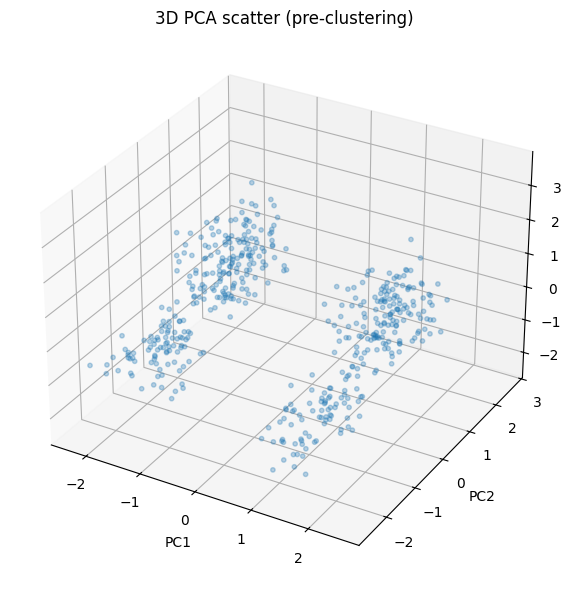

In [18]:

# 11.1) 3D PCA visualization — Practice

if APPLY_PCA and hasattr(globals().get("pca", None), "n_components_") and getattr(pca, "n_components_", 0) >= 3:
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    # placeholders before clustering
    ax.scatter(X_emb[:,0], X_emb[:,1], X_emb[:,2], s=10, alpha=0.3)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    ax.set_title("3D PCA scatter (pre-clustering)")
    plt.tight_layout(); plt.show()
else:
    print("3D PCA requires APPLY_PCA=True and PCA_N_COMPONENTS >= 3")



## 12) Clustering Models

Pick KMeans, GMM, Agglomerative, DBSCAN, or Spectral based on data structure.


In [19]:

# 12) Clustering Models — Practice

# KMeans
K = 5
K_INIT = "k-means++"
K_N_INIT = "auto"
K_MAX_ITER = 300

# GMM
GMM_COMPONENTS = 5
GMM_COV_TYPE = "full"
GMM_REG_COV = 1e-6

# Agglomerative
AGGLO_N_CLUSTERS = 5
AGGLO_LINKAGE = "ward"

# DBSCAN
DBSCAN_EPS = 0.7
DBSCAN_MIN_SAMPLES = 10
DBSCAN_METRIC = "euclidean"

# Spectral
SPECTRAL_N_CLUSTERS = 5
SPECTRAL_ASSIGN_LABELS = "kmeans"
SPECTRAL_AFFINITY = "nearest_neighbors"

# Fit + labels
if ALGO == "kmeans":
    model = KMeans(n_clusters=K, init=K_INIT, n_init=K_N_INIT, max_iter=K_MAX_ITER, random_state=RANDOM_STATE)
    model.fit(X_emb)
    labels = model.labels_.astype(int)
elif ALGO == "gmm":
    model = GaussianMixture(n_components=GMM_COMPONENTS, covariance_type=GMM_COV_TYPE, reg_covar=GMM_REG_COV, random_state=RANDOM_STATE)
    model.fit(X_emb)
    labels = model.predict(X_emb).astype(int)
elif ALGO == "agglo":
    model = AgglomerativeClustering(n_clusters=AGGLO_N_CLUSTERS, linkage=AGGLO_LINKAGE)
    labels = model.fit_predict(X_emb).astype(int)
elif ALGO == "dbscan":
    model = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES, metric=DBSCAN_METRIC)
    labels = model.fit_predict(X_emb).astype(int)  # -1 = noise
elif ALGO == "spectral":
    model = SpectralClustering(n_clusters=SPECTRAL_N_CLUSTERS, affinity=SPECTRAL_AFFINITY, assign_labels=SPECTRAL_ASSIGN_LABELS, random_state=RANDOM_STATE)
    labels = model.fit_predict(X_emb).astype(int)
else:
    raise ValueError("Unsupported ALGO")

work["cluster"] = labels
print("Cluster counts:")
display(work["cluster"].value_counts(dropna=False).sort_index())
display(work[[ID_COL, "cluster"]].head(10))


Cluster counts:


cluster
0     96
1     87
2     99
3    128
4     87
Name: count, dtype: int64

,professional_id,cluster
0,1,2
1,2,3
2,3,0
3,4,3
4,5,2
5,6,0
6,7,0
7,8,1
8,9,0
9,10,3



## 13) Hyperparameter Sweeps

Evaluate parameter grids with internal indices and information criteria.


In [20]:

# 13) Hyperparameter Sweeps — Practice

if DO_SWEEP and ALGO == "kmeans":
    rows = []
    for k in K_RANGE:
        mdl = KMeans(n_clusters=k, init=K_INIT, n_init=K_N_INIT, max_iter=K_MAX_ITER, random_state=RANDOM_STATE)
        mdl.fit(X_emb)
        y = mdl.labels_.astype(int)
        inertia = getattr(mdl, "inertia_", np.nan)
        if len(np.unique(y)) > 1 and len(np.unique(y)) < len(y):
            sil = silhouette_score(X_emb, y); dbi = davies_bouldin_score(X_emb, y); ch = calinski_harabasz_score(X_emb, y)
        else:
            sil, dbi, ch = np.nan, np.nan, np.nan
        rows.append(dict(k=k, inertia=inertia, silhouette=sil, davies_bouldin=dbi, calinski_harabasz=ch))
    sweep_kmeans = pd.DataFrame(rows); display(sweep_kmeans.sort_values(["silhouette","calinski_harabasz"], ascending=[False, False]).head(10))

elif DO_SWEEP and ALGO == "gmm":
    rows = []
    for k in GMM_RANGE:
        mdl = GaussianMixture(n_components=k, covariance_type=GMM_COV_TYPE, reg_covar=GMM_REG_COV, random_state=RANDOM_STATE)
        mdl.fit(X_emb)
        y = mdl.predict(X_emb).astype(int)
        bic = mdl.bic(X_emb); aic = mdl.aic(X_emb)
        if len(np.unique(y)) > 1 and len(np.unique(y)) < len(y):
            sil = silhouette_score(X_emb, y); dbi = davies_bouldin_score(X_emb, y); ch = calinski_harabasz_score(X_emb, y)
        else:
            sil, dbi, ch = np.nan, np.nan, np.nan
        rows.append(dict(components=k, bic=bic, aic=aic, silhouette=sil, davies_bouldin=dbi, calinski_harabasz=ch))
    sweep_gmm = pd.DataFrame(rows); display(sweep_gmm.sort_values(["bic","aic"], ascending=[True, True]).head(10))

elif DO_SWEEP and ALGO == "dbscan":
    rows = []
    for eps in DBSCAN_EPS_GRID:
        for ms in DBSCAN_MIN_SAMPLES_GRID:
            mdl = DBSCAN(eps=eps, min_samples=ms, metric="euclidean")
            y = mdl.fit_predict(X_emb).astype(int)
            k = len(set(y)) - (1 if -1 in set(y) else 0)
            if k > 1 and np.any(y != -1):
                mask = y != -1; X_eval, y_eval = X_emb[mask], y[mask]
                if len(np.unique(y_eval)) > 1:
                    sil = silhouette_score(X_eval, y_eval); dbi = davies_bouldin_score(X_eval, y_eval); ch = calinski_harabasz_score(X_eval, y_eval)
                else:
                    sil, dbi, ch = np.nan, np.nan, np.nan
            else:
                sil, dbi, ch = np.nan, np.nan, np.nan
            rows.append(dict(eps=eps, min_samples=ms, clusters=k, silhouette=sil, davies_bouldin=dbi, calinski_harabasz=ch))
    sweep_dbscan = pd.DataFrame(rows); display(sweep_dbscan.sort_values(["silhouette","calinski_harabasz"], ascending=[False, False]).head(10))
else:
    print("Sweep disabled or not applicable for current ALGO.")


,k,inertia,silhouette,davies_bouldin,calinski_harabasz
4,6,376.260004,0.546193,0.596475,597.105828
5,7,346.506008,0.502707,0.733118,546.227571
3,5,634.210622,0.477899,0.762511,393.682839
6,8,319.867345,0.475710,0.832879,511.969160
7,9,300.801438,0.414205,0.940479,479.259440
8,10,274.742849,0.394008,0.990283,470.590613
9,11,264.342246,0.392233,0.968937,441.203777
2,4,990.262844,0.392174,0.970489,277.773897
0,2,1673.384218,0.375053,1.241575,293.064869
1,3,1327.070595,0.356381,1.075201,248.855762



## 14) Validation Metrics — Theory

Internal validation indices quantify compactness and separation.

**Silhouette (point $i$)**  
Let $a(i)$ be the mean intra-cluster distance and $b(i)$ the smallest mean inter-cluster distance:
$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

**Davies–Bouldin (DBI)**  
Cluster scatter $S_i$ and centroid distances $M_{ij}$:
$$
R_{ij} = \frac{S_i + S_j}{M_{ij}}, \quad R_i = \max_{j\ne i} R_{ij}, \quad
DBI = \frac{1}{k}\sum_{i=1}^k R_i
$$

**Calinski–Harabasz (CH)**  
Between- vs within-cluster dispersion matrices $B_k, W_k$:
$$
CH(k) = \frac{\mathrm{tr}(B_k)/(k-1)}{\mathrm{tr}(W_k)/(n-k)}
$$


In [21]:

# 14) Validation Metrics — Practice

labels = work["cluster"].values
unique_clusters = sorted(set(labels))
valid = (len(unique_clusters) > 1) and (len(unique_clusters) < len(labels))

if valid:
    if -1 in unique_clusters:
        mask = labels != -1; X_eval = X_emb[mask]; y_eval = labels[mask]
    else:
        X_eval = X_emb; y_eval = labels
    if len(np.unique(y_eval)) > 1:
        sil = silhouette_score(X_eval, y_eval); dbi = davies_bouldin_score(X_eval, y_eval); ch = calinski_harabasz_score(X_eval, y_eval)
    else:
        sil, dbi, ch = np.nan, np.nan, np.nan
else:
    sil, dbi, ch = np.nan, np.nan, np.nan

print({"silhouette": sil, "davies_bouldin": dbi, "calinski_harabasz": ch})


{'silhouette': 0.47789912494466413, 'davies_bouldin': 0.7625111998322025, 'calinski_harabasz': 393.6828386693418}



## 15) Visualization

2D embedding scatter with cluster centroids.


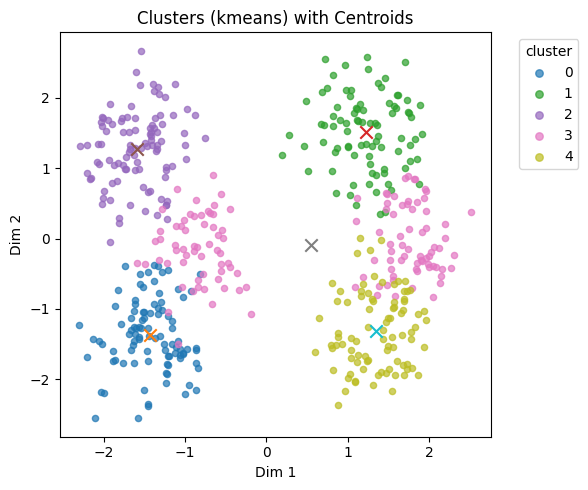

In [22]:

# 15) Visualization — Practice

plt.figure(figsize=(6,5))
labels = work["cluster"].values
unique = sorted(set(labels))
for u in unique:
    mask = labels == u
    plt.scatter(X_emb[mask, 0], X_emb[mask, 1], s=20, label=str(u), alpha=0.7)
    cx, cy = X_emb[mask, 0].mean(), X_emb[mask, 1].mean()
    plt.scatter(cx, cy, marker="x", s=80)
plt.xlabel("Dim 1"); plt.ylabel("Dim 2"); plt.title(f"Clusters ({ALGO}) with Centroids")
plt.legend(title="cluster", markerscale=1.2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout(); plt.show()



## 16) Cluster Profiling

Summarize clusters using raw means and standardized means. Standardization:
$$
z = \frac{x - \mu}{\sigma}
$$


In [23]:

# 16) Cluster Profiling — Practice

profile = work[[ID_COL, "cluster"] + [c for c in FEATURES if c in work.columns]].copy()

mu = profile[[c for c in FEATURES if c in profile.columns]].mean()
sd = profile[[c for c in FEATURES if c in profile.columns]].std(ddof=0).replace(0, np.nan)

zcols = []
for c in FEATURES:
    if c in profile.columns:
        zc = f"z_{c}"
        profile[zc] = (profile[c] - mu[c]) / sd[c]
        zcols.append(zc)

counts = profile["cluster"].value_counts().sort_index().to_frame("n")
feature_means = profile.groupby("cluster")[[c for c in FEATURES if c in profile.columns]].mean().round(3)
z_means = profile.groupby("cluster")[zcols].mean().round(2)

print("Counts"); display(counts)
print("Feature means by cluster"); display(feature_means)
print("Standardized means (z-scores) by cluster"); display(z_means)


Counts


,n
cluster,
0,96
1,87
2,99
3,128
4,87


Feature means by cluster


,total_bookings,avg_rating,total_income,total_work_hour,avg_booking_per_month,avg_income_per_month,avg_work_hour_per_month,latest_month_booking,latest_month_rating,latest_diff_avg_booking,...,tenures,province_Bangkok,province_Chiang Mai,province_Khon Kaen,province_Phuket,training_center_A,training_center_B,training_center_C,gender_Female,gender_Male
cluster,,,,,,,,,,,,,,,,,,,,,
0,49.656,4.526,1058.483,164.646,5.021,216.317,59.552,4.823,4.428,-0.138,...,28.698,0.333,0.198,0.188,0.281,0.073,0.927,0.000,1.000,0.000
1,50.632,4.509,1026.720,182.161,5.299,198.879,62.276,4.816,4.310,0.319,...,28.724,0.207,0.276,0.230,0.287,0.057,0.000,0.943,0.000,1.000
2,49.202,4.559,976.631,168.626,4.808,201.206,60.768,4.677,4.498,-0.242,...,30.131,0.293,0.242,0.162,0.303,0.040,0.000,0.960,1.000,0.000
3,49.719,4.484,1019.456,160.102,4.961,170.907,62.273,5.070,4.357,-0.121,...,32.812,0.156,0.336,0.312,0.195,1.000,0.000,0.000,0.469,0.531
4,48.701,4.535,991.883,191.184,5.011,174.112,59.080,5.034,4.458,-0.042,...,30.103,0.287,0.276,0.184,0.253,0.069,0.931,0.000,0.000,1.000


Standardized means (z-scores) by cluster


,z_total_bookings,z_avg_rating,z_total_income,z_total_work_hour,z_avg_booking_per_month,z_avg_income_per_month,z_avg_work_hour_per_month,z_latest_month_booking,z_latest_month_rating,z_latest_diff_avg_booking,...,z_tenures,z_province_Bangkok,z_province_Chiang Mai,z_province_Khon Kaen,z_province_Phuket,z_training_center_A,z_training_center_B,z_training_center_C,z_gender_Female,z_gender_Male
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.01,0.02,0.10,-0.10,0.00,0.19,-0.06,-0.03,0.05,-0.04,...,-0.09,0.19,-0.16,-0.08,0.05,-0.50,1.23,-0.74,0.97,-0.97
1,0.14,-0.04,0.03,0.15,0.13,0.06,0.06,-0.04,-0.26,0.20,...,-0.09,-0.10,0.01,0.02,0.06,-0.53,-0.72,1.22,-1.03,1.03
2,-0.05,0.14,-0.09,-0.05,-0.09,0.08,-0.01,-0.10,0.23,-0.10,...,-0.01,0.10,-0.06,-0.14,0.10,-0.57,-0.72,1.26,0.97,-0.97
3,0.02,-0.13,0.01,-0.17,-0.02,-0.15,0.06,0.08,-0.13,-0.03,...,0.15,-0.22,0.15,0.22,-0.15,1.52,-0.72,-0.74,-0.09,0.09
4,-0.12,0.05,-0.05,0.27,0.00,-0.13,-0.08,0.07,0.13,0.01,...,-0.01,0.09,0.01,-0.09,-0.02,-0.51,1.24,-0.74,-1.03,1.03



## 16.1) Cluster Characteristic Visualization

Per-feature distributions across clusters via box, violin, and mean bars.


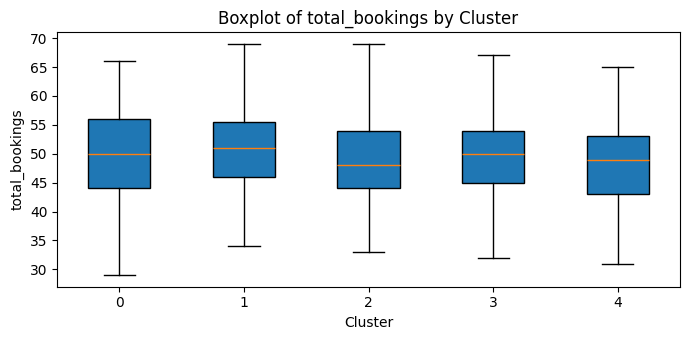

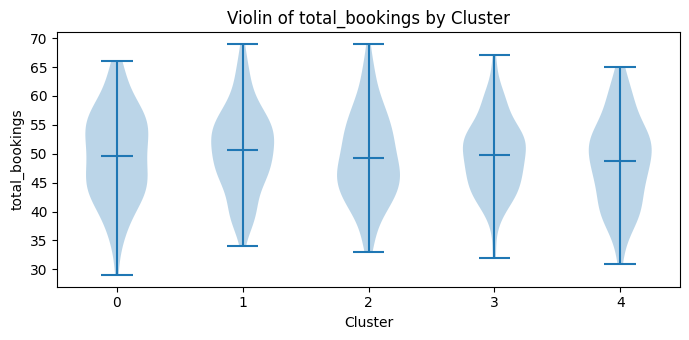

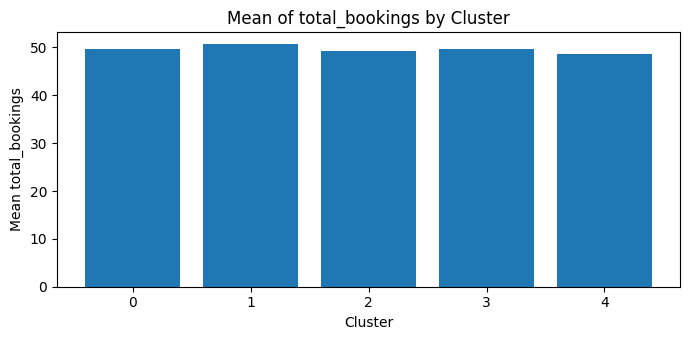

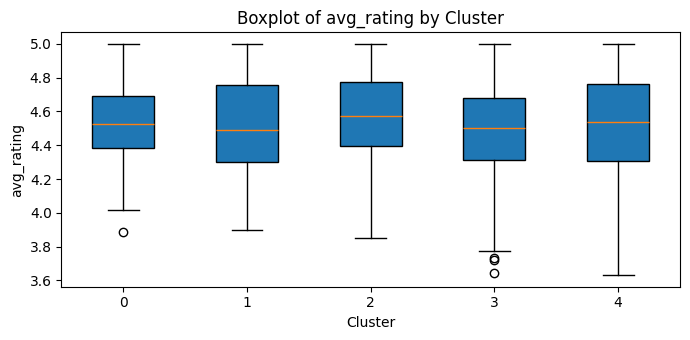

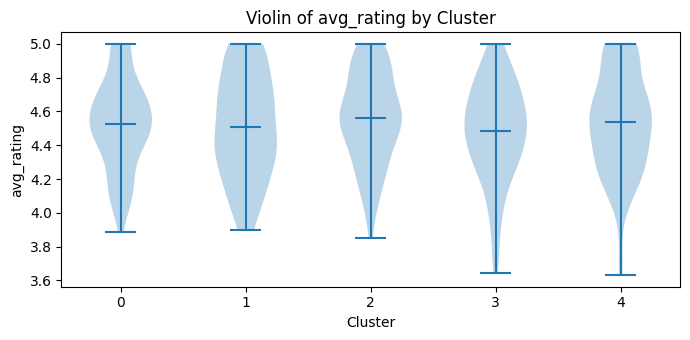

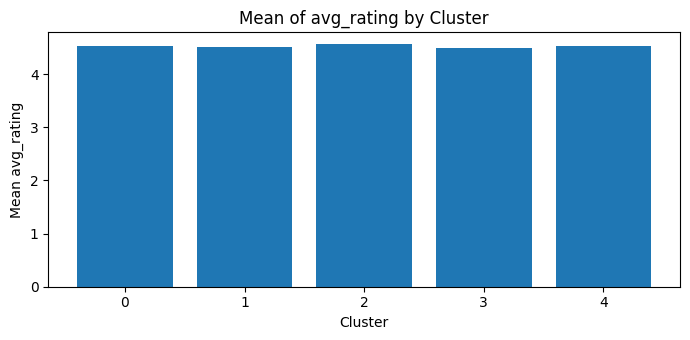

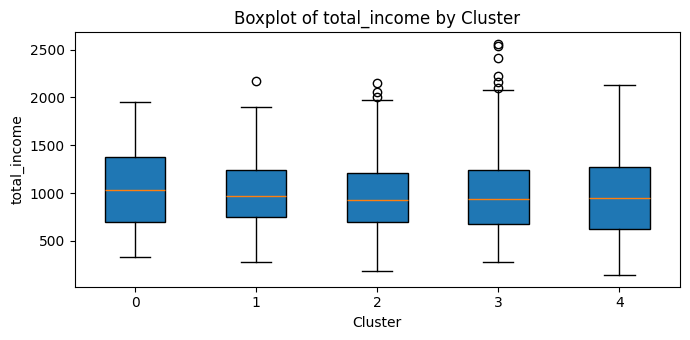

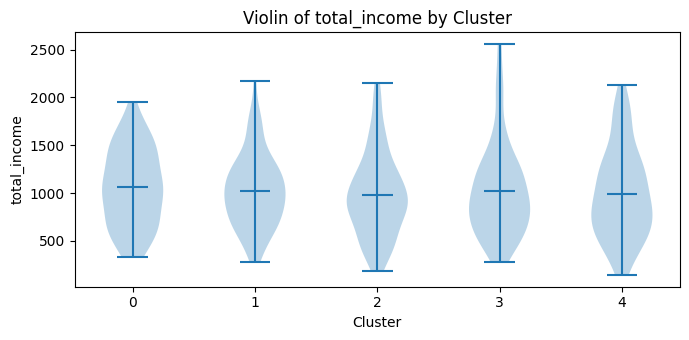

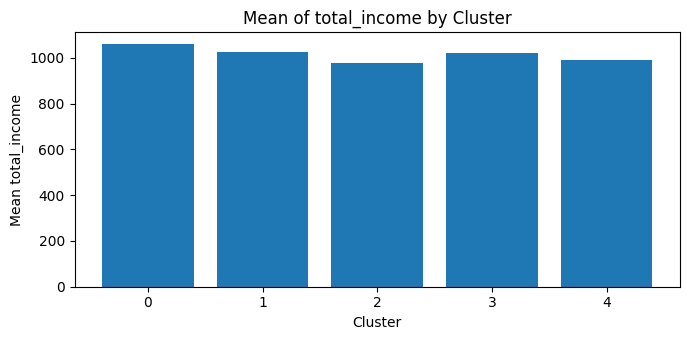

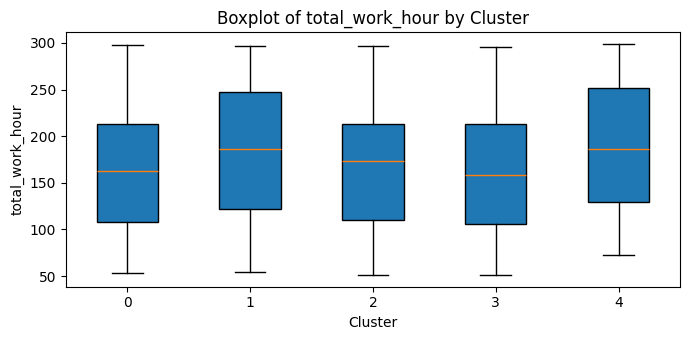

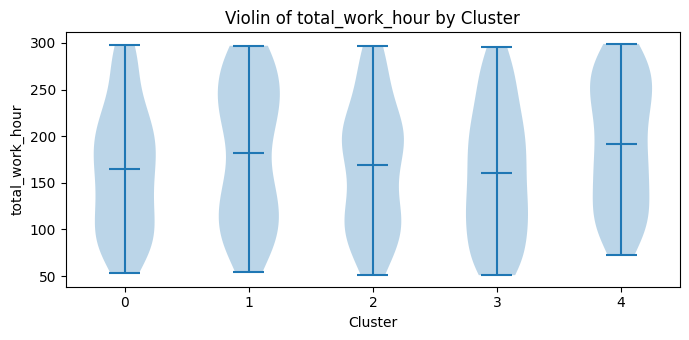

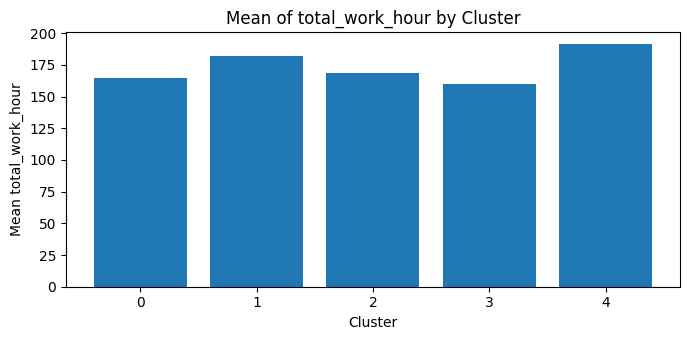

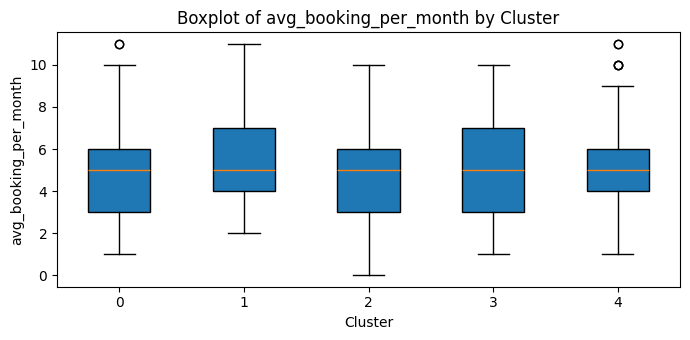

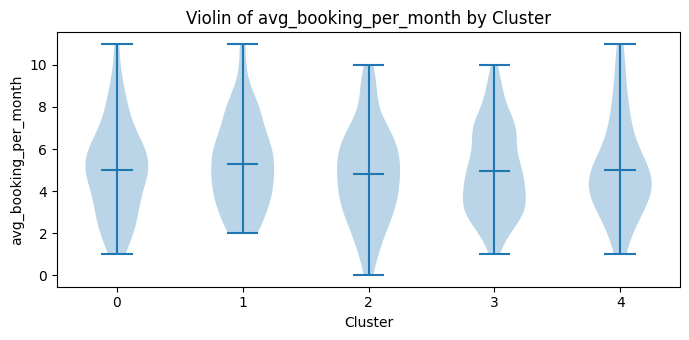

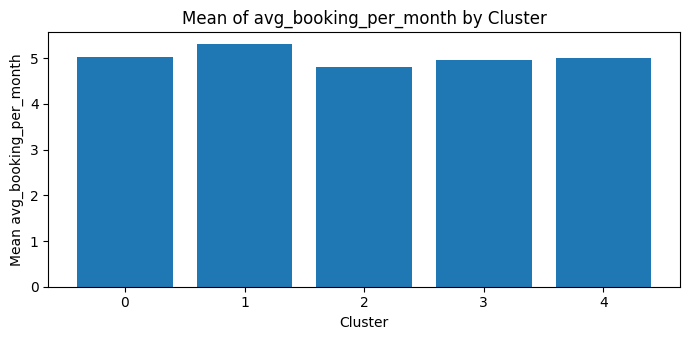

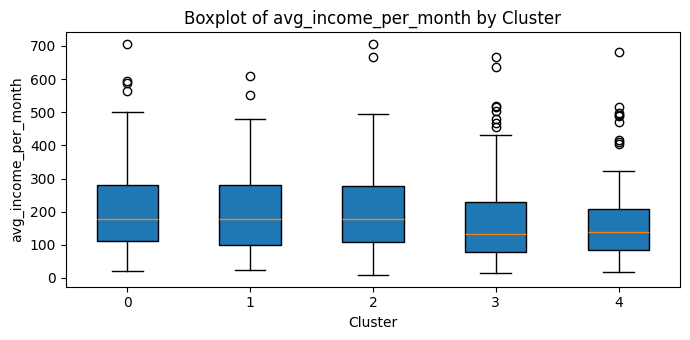

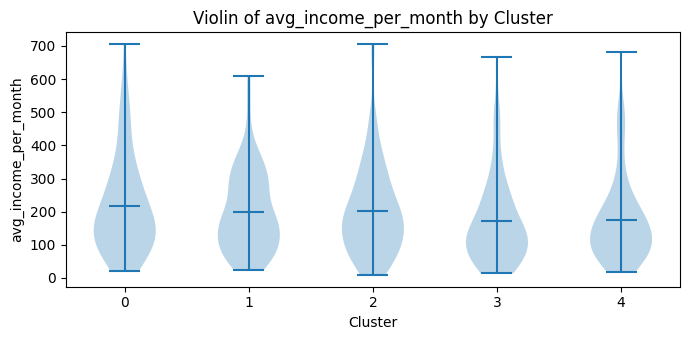

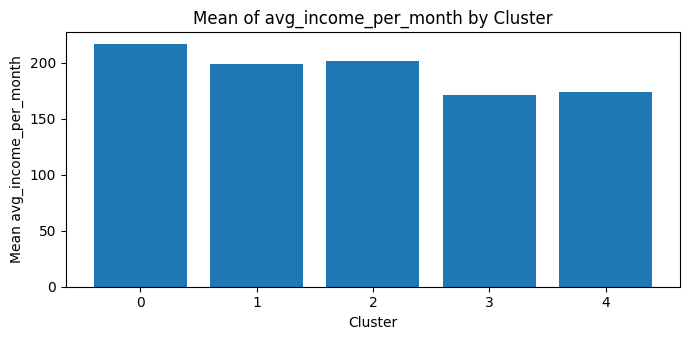

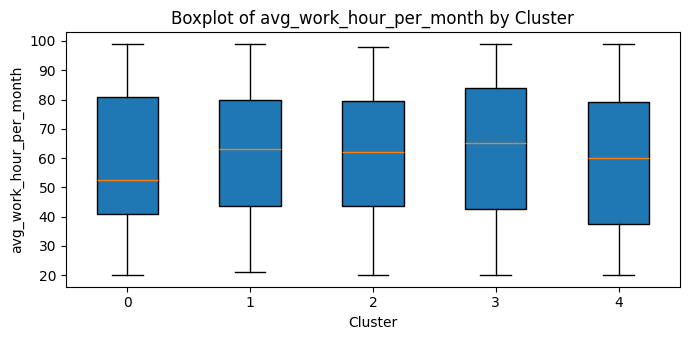

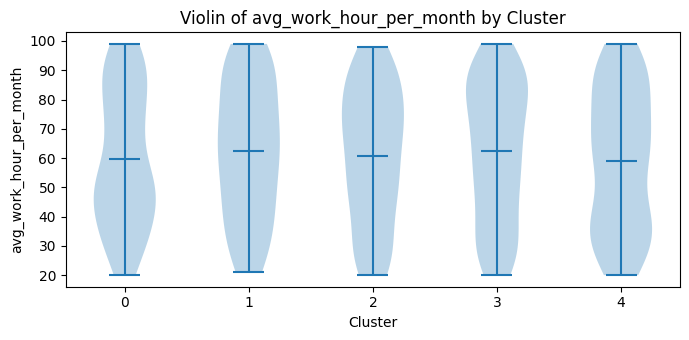

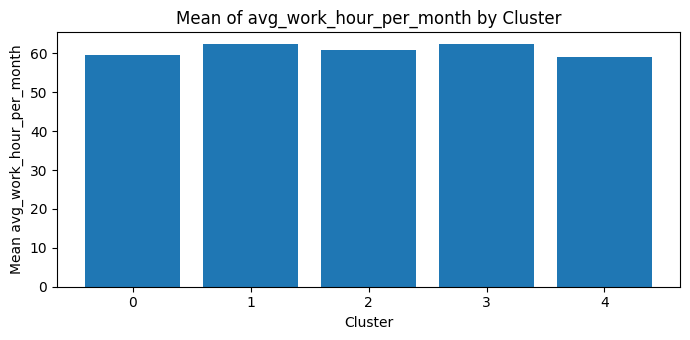

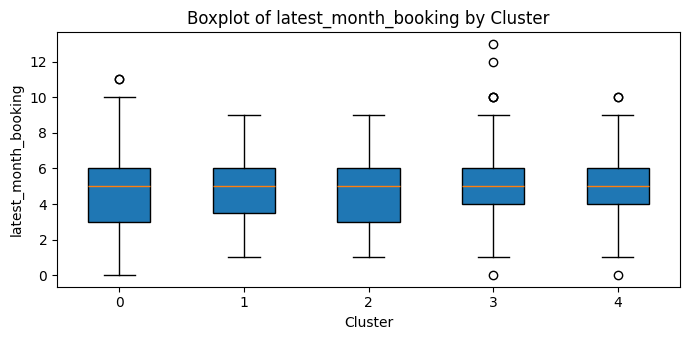

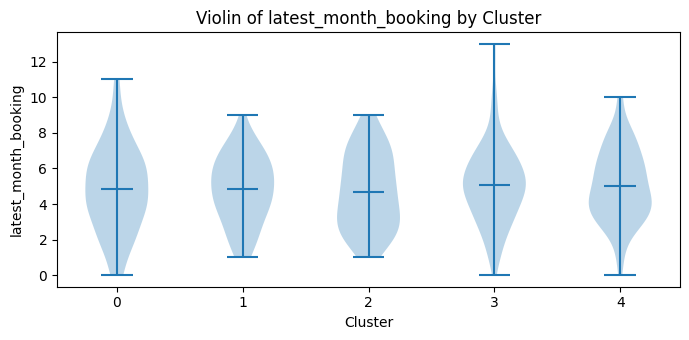

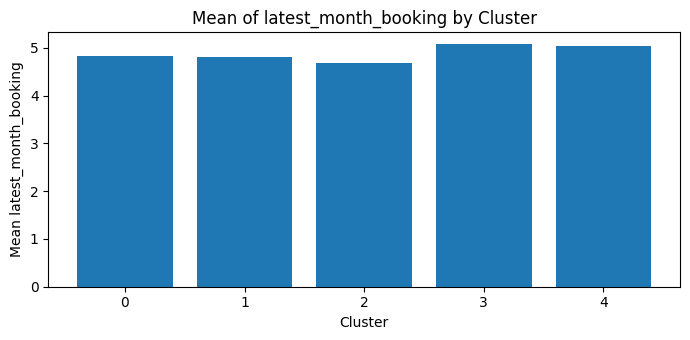

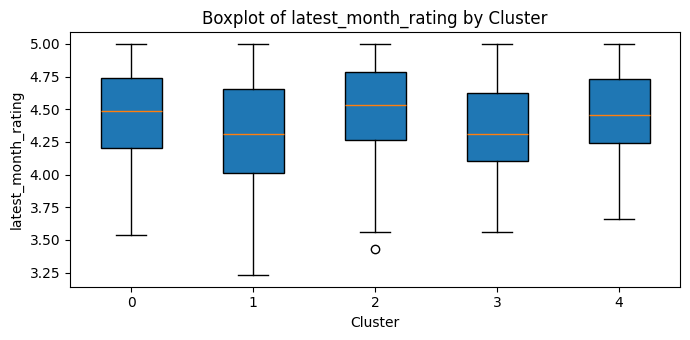

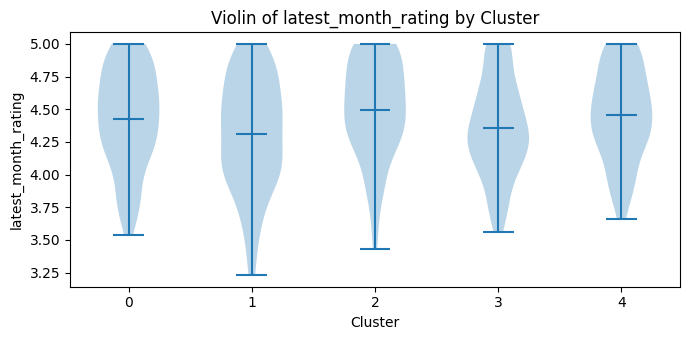

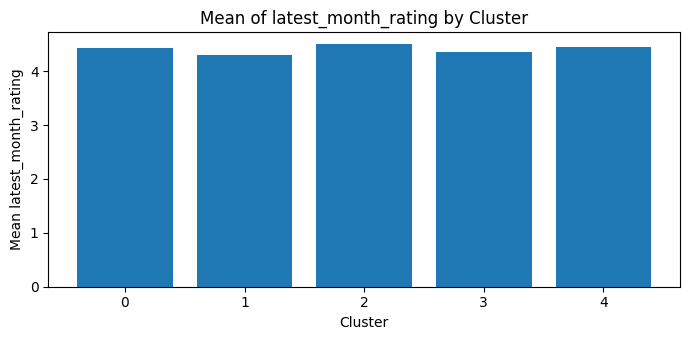

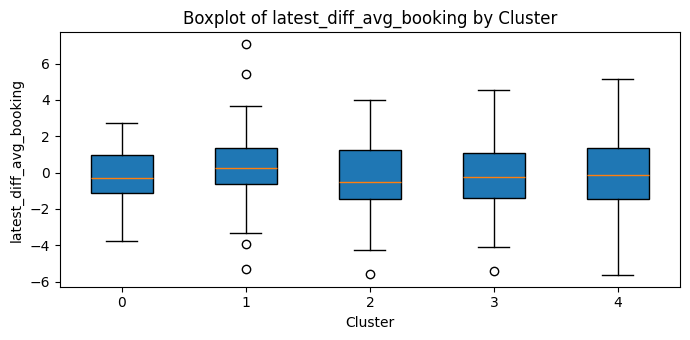

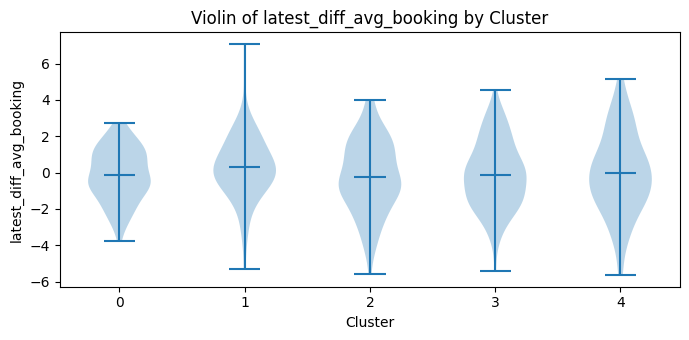

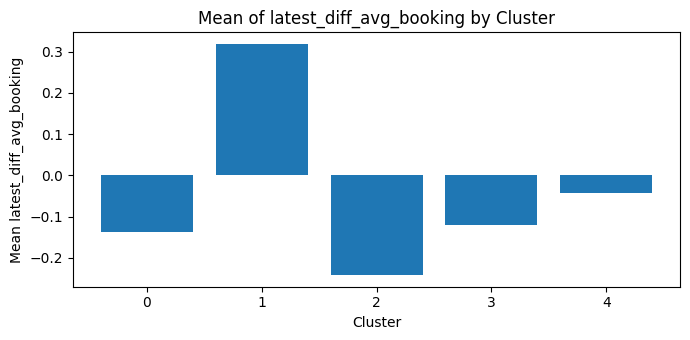

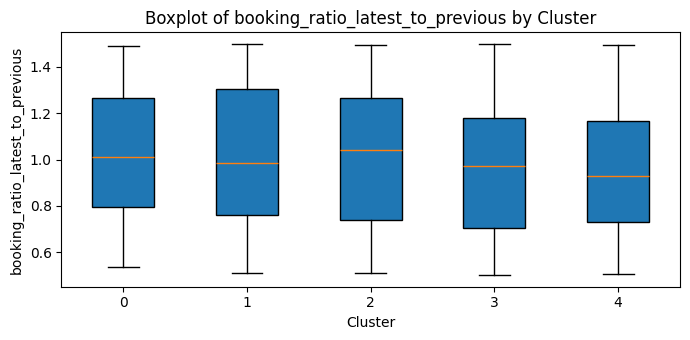

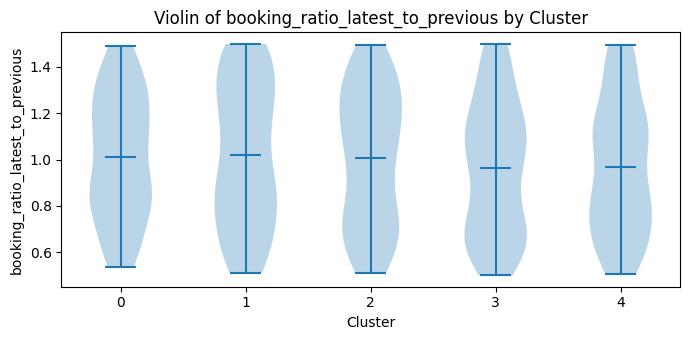

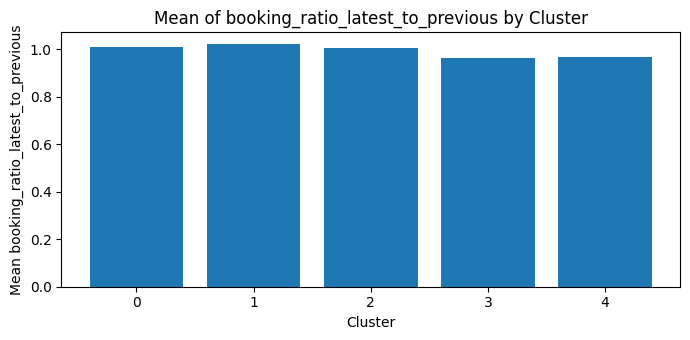

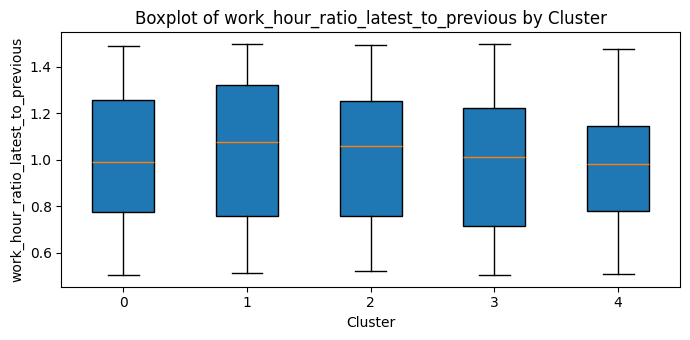

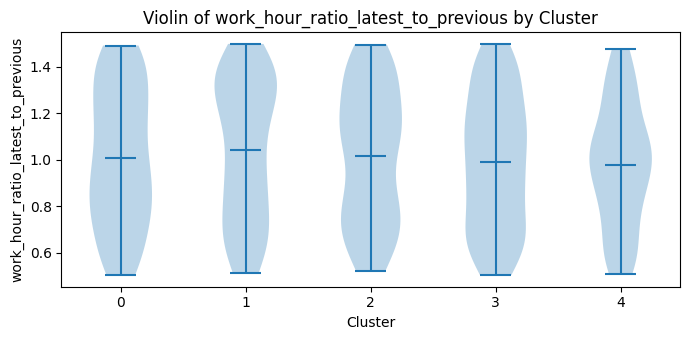

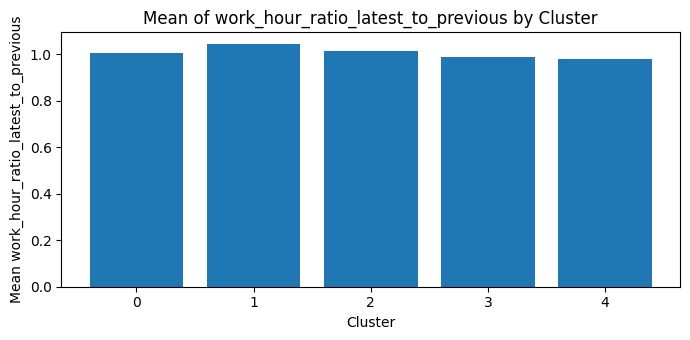

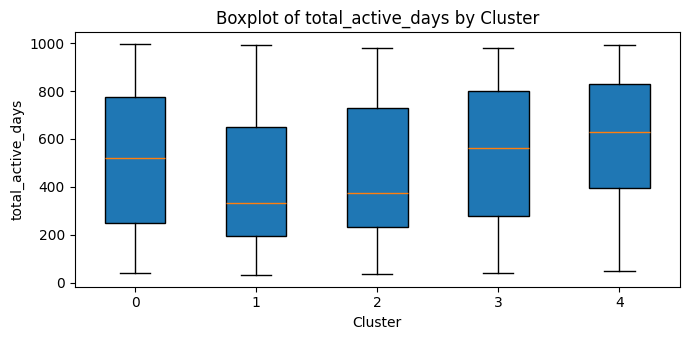

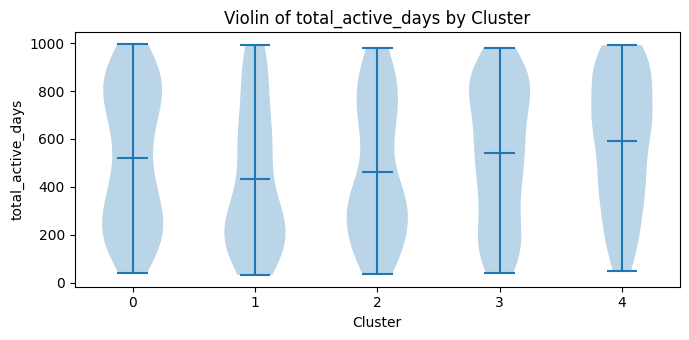

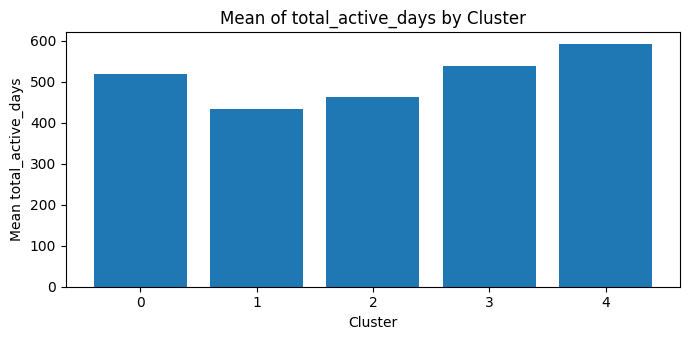

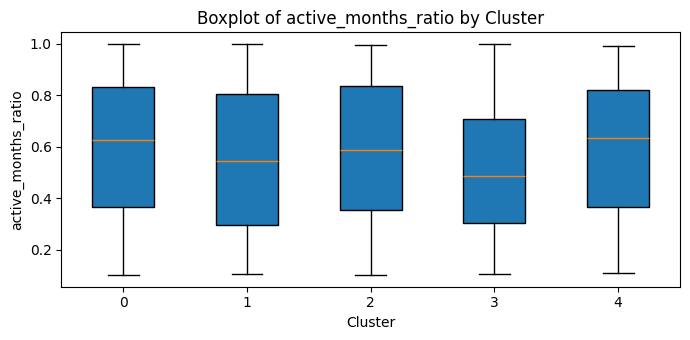

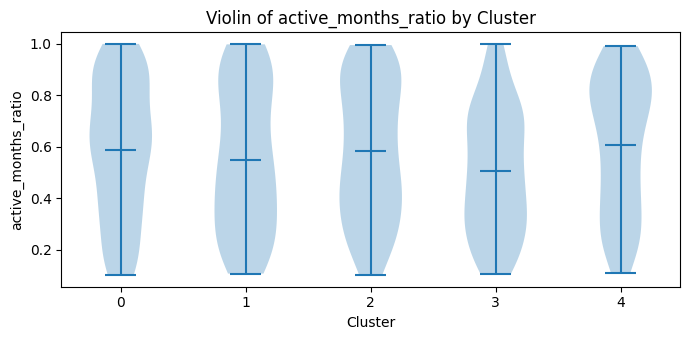

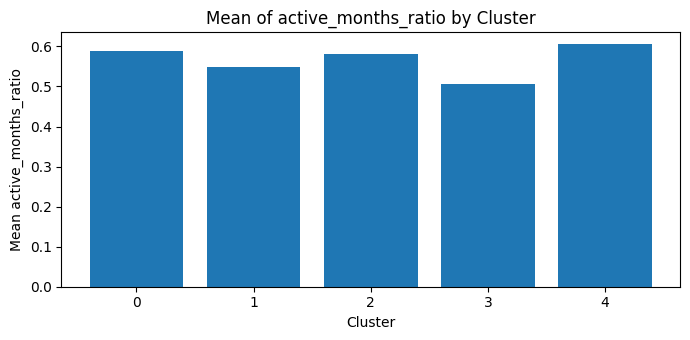

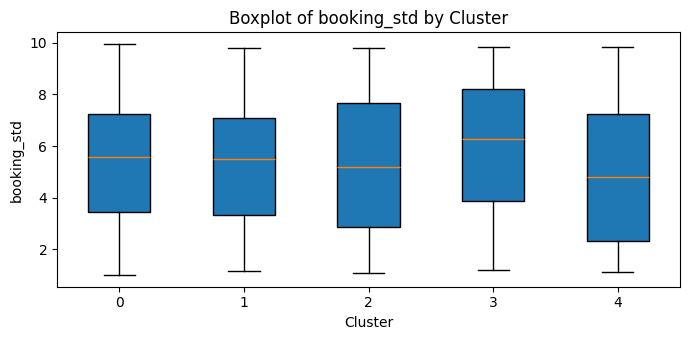

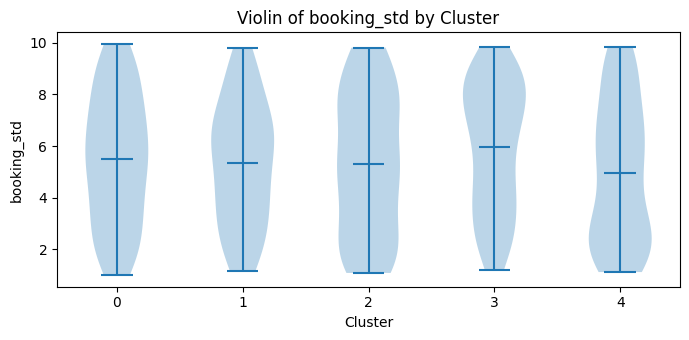

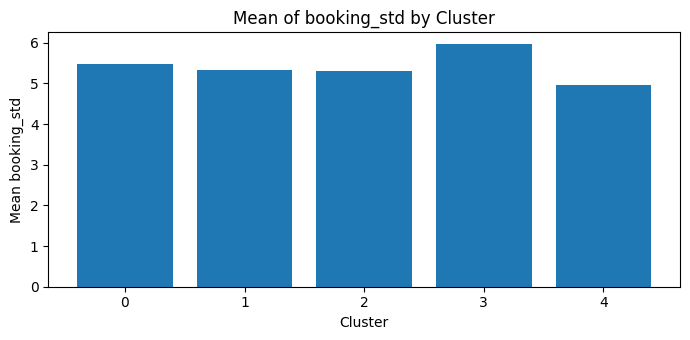

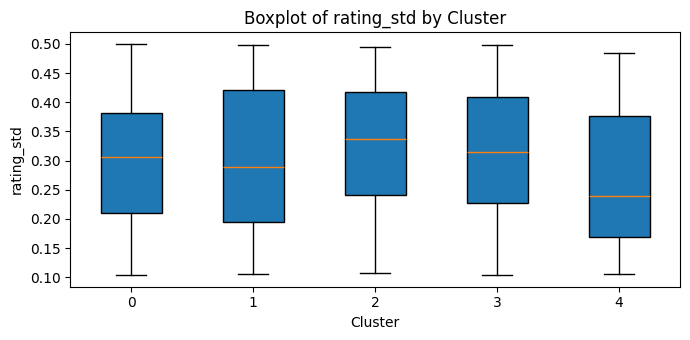

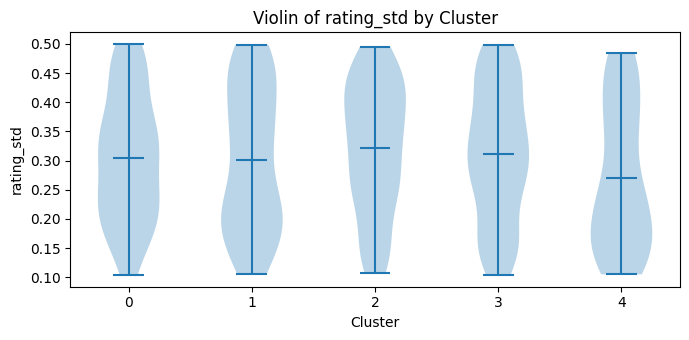

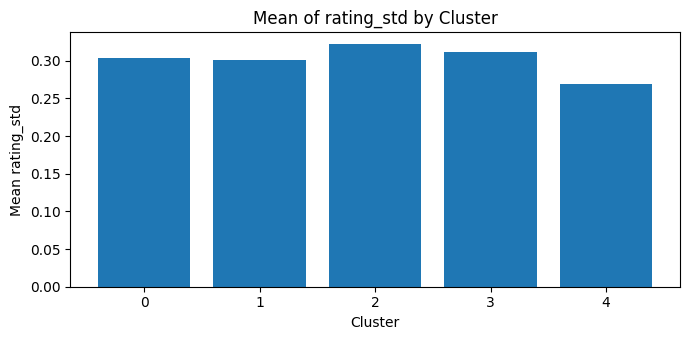

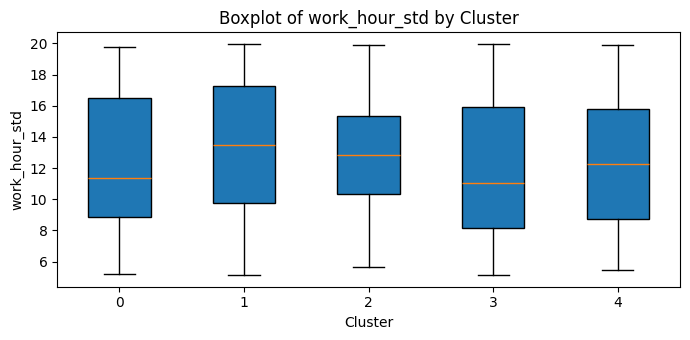

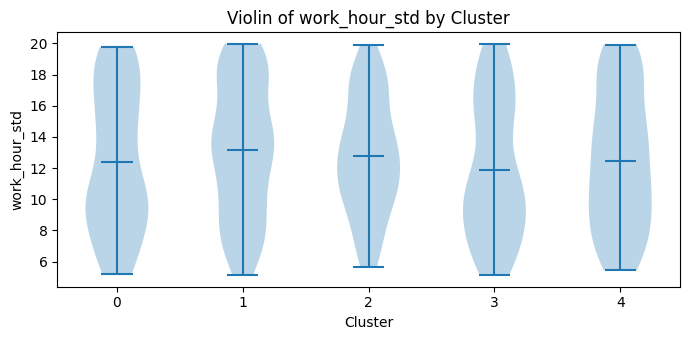

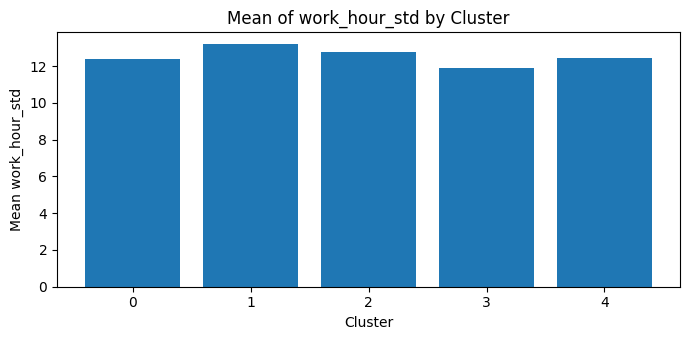

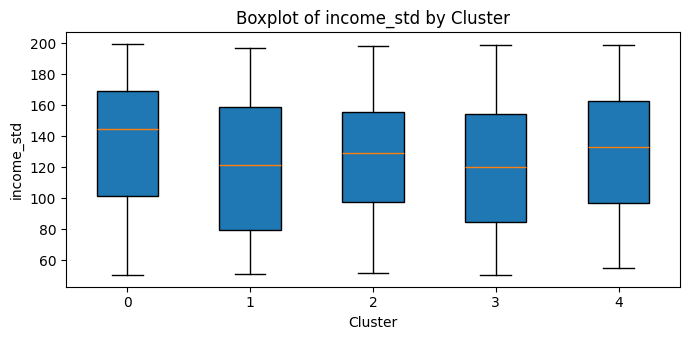

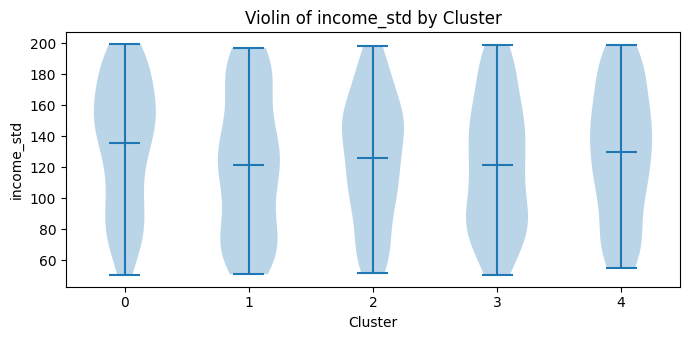

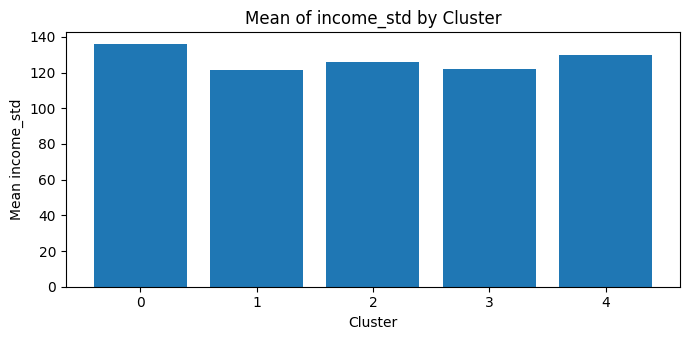

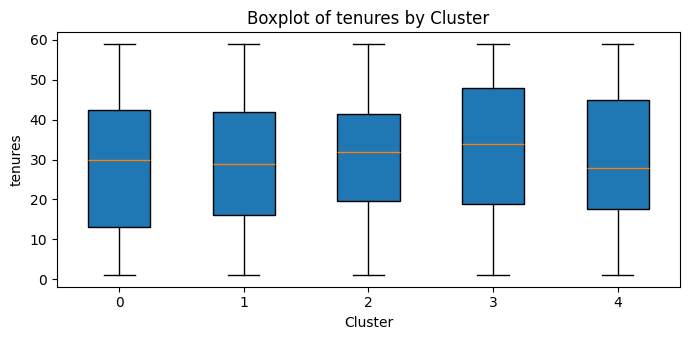

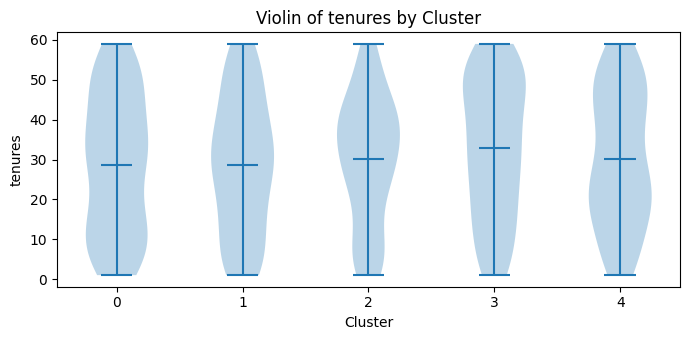

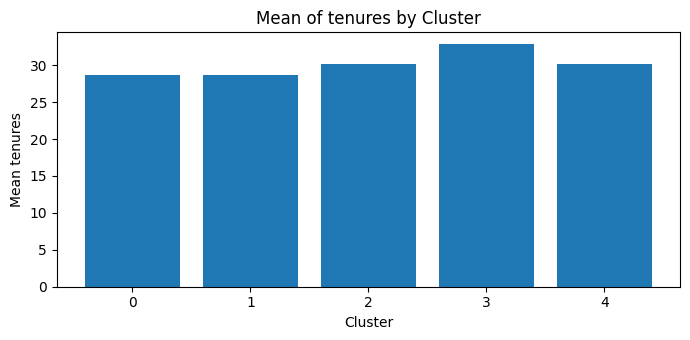

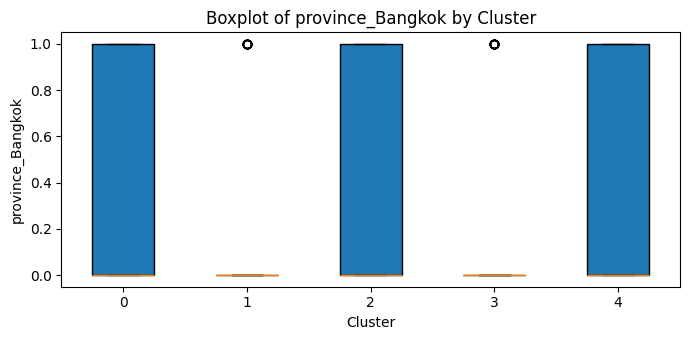

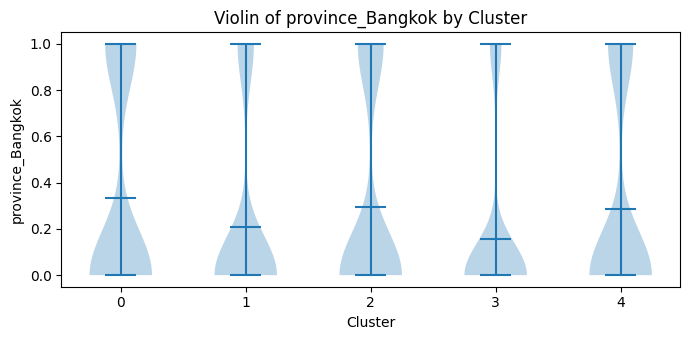

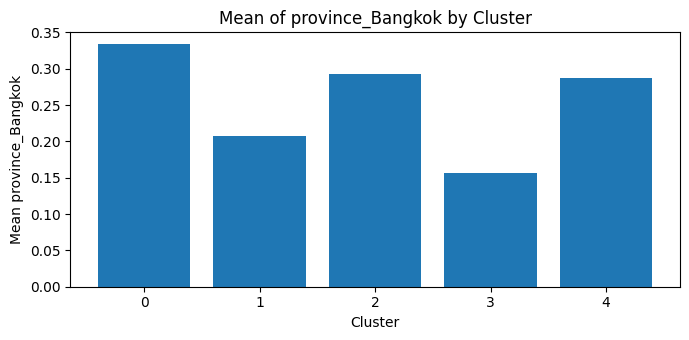

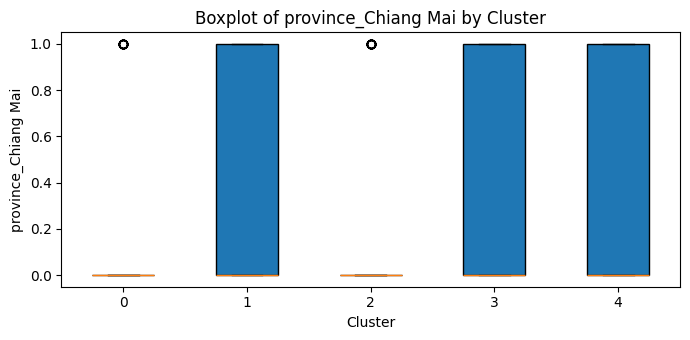

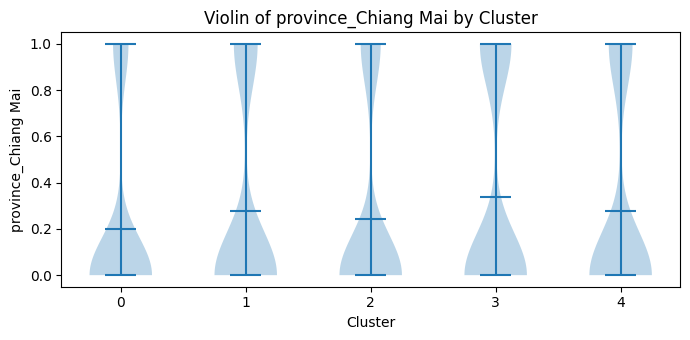

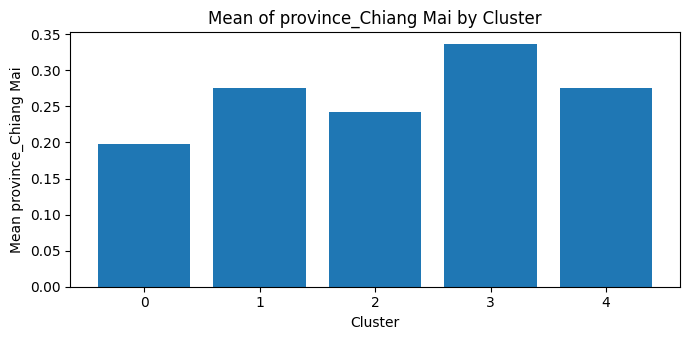

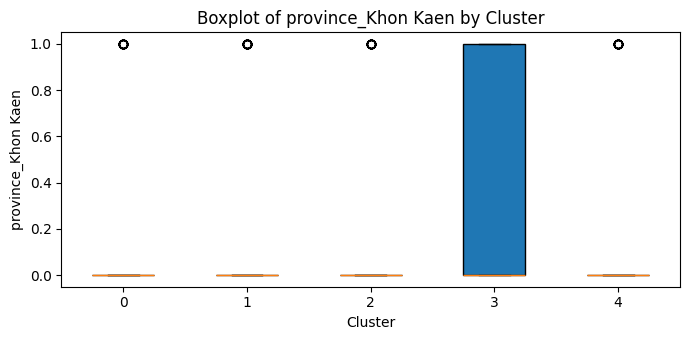

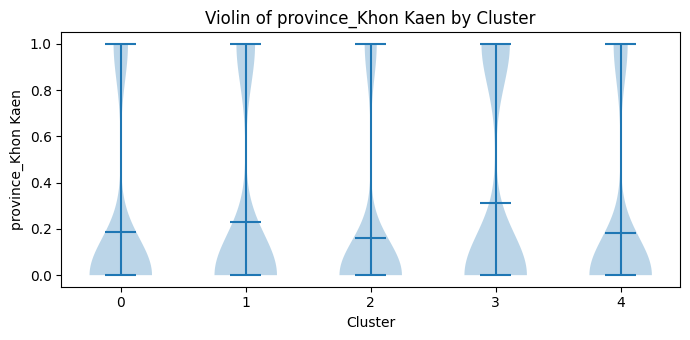

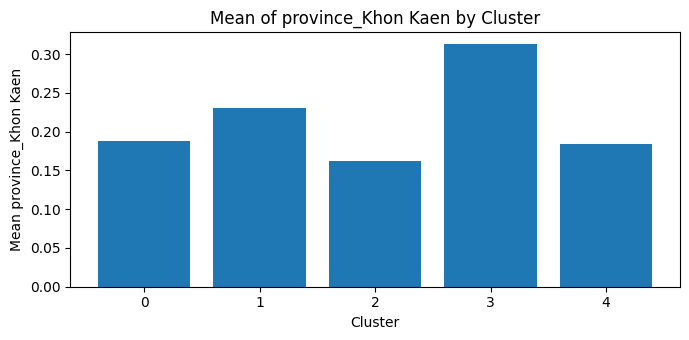

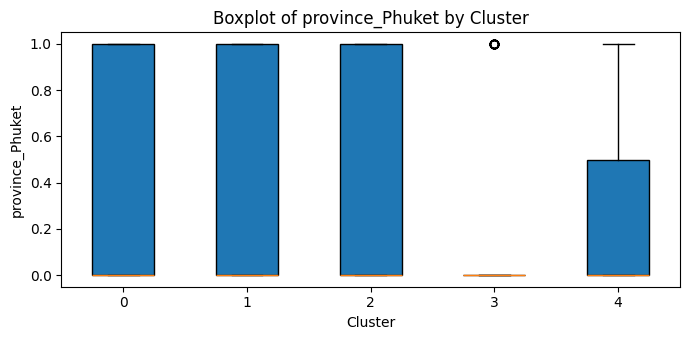

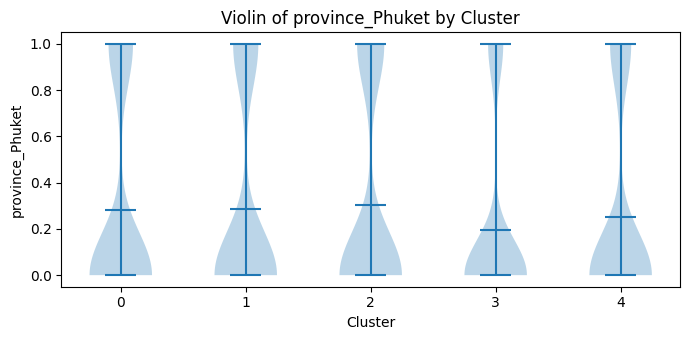

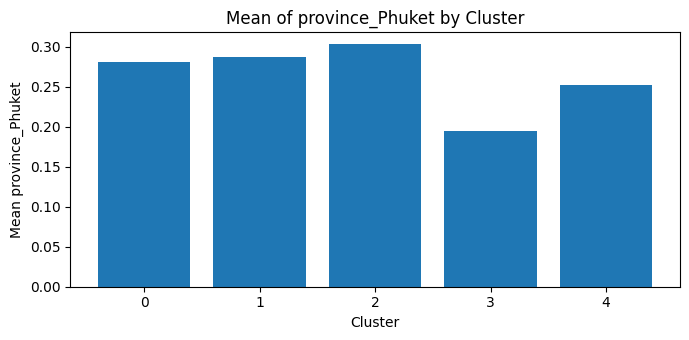

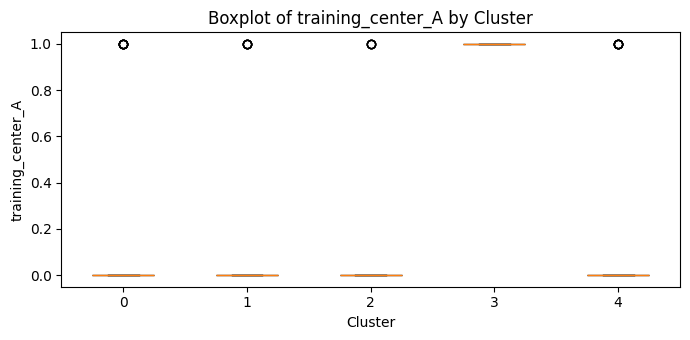

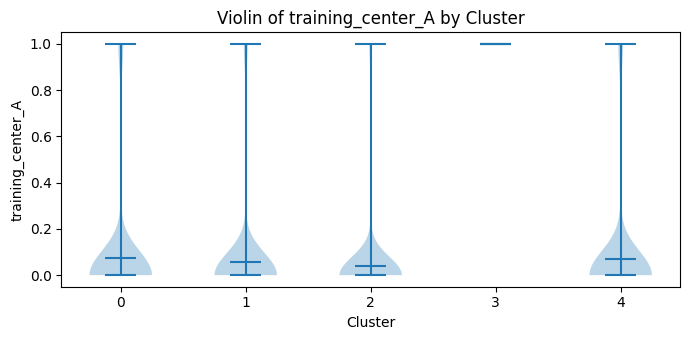

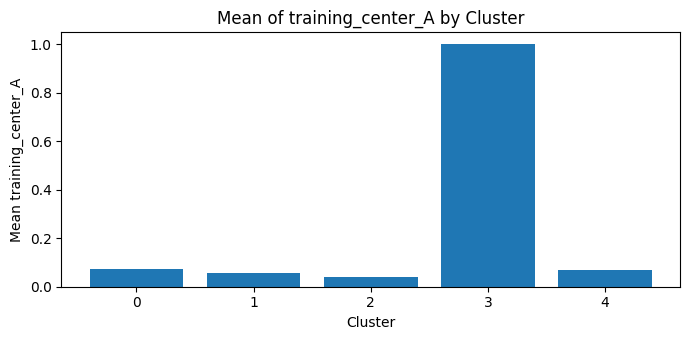

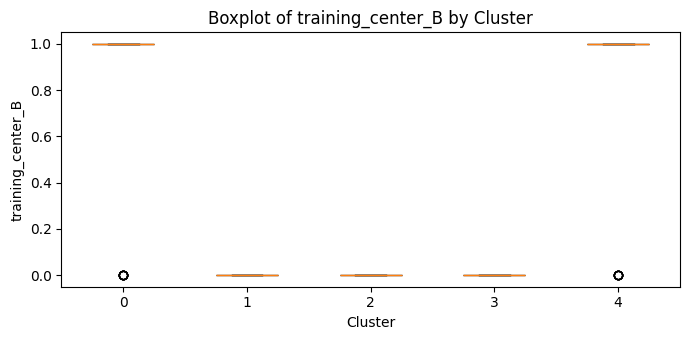

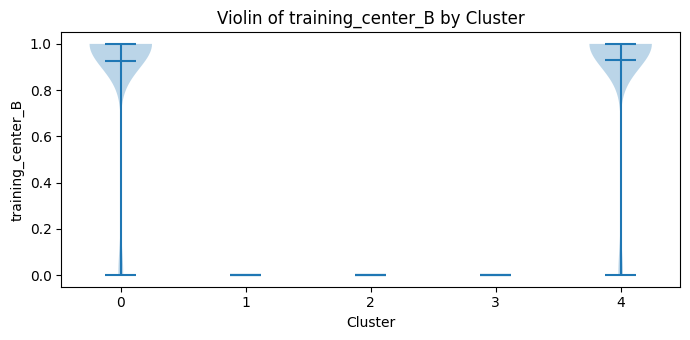

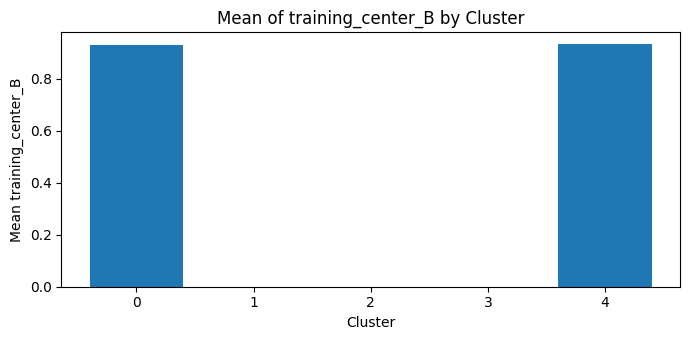

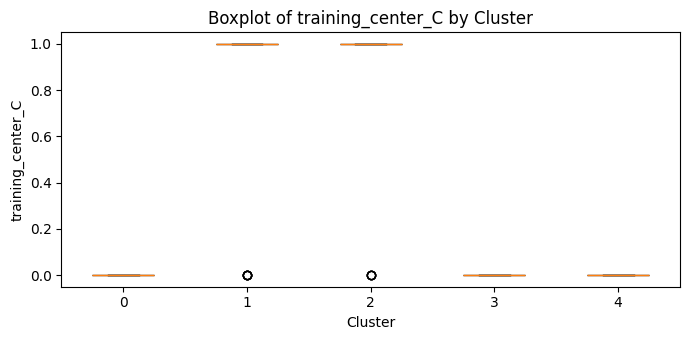

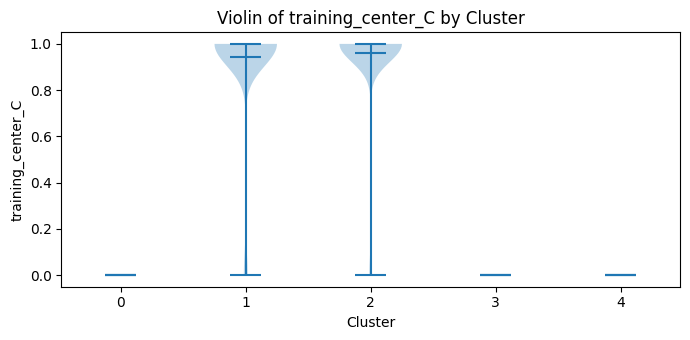

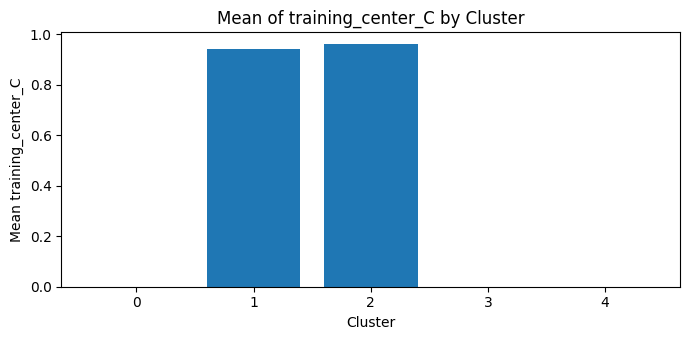

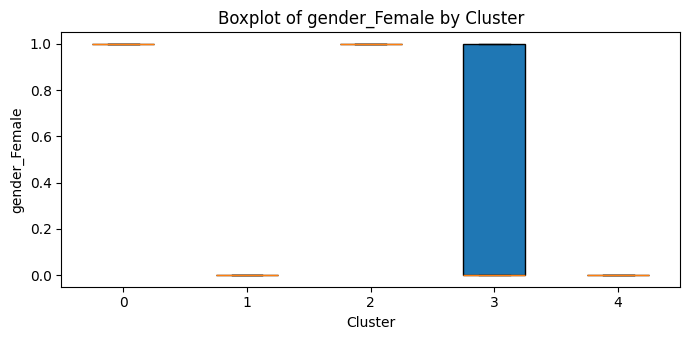

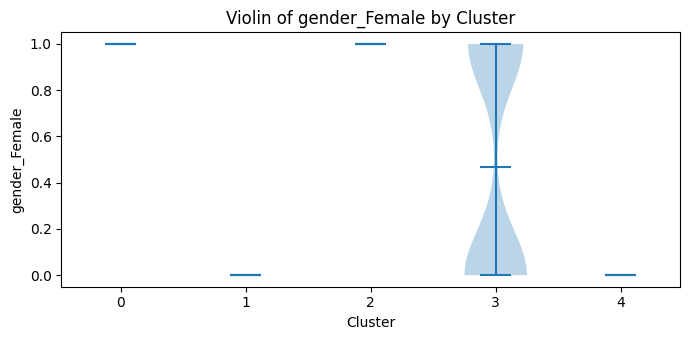

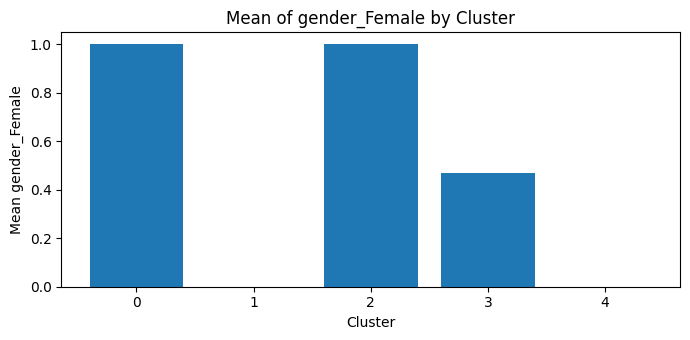

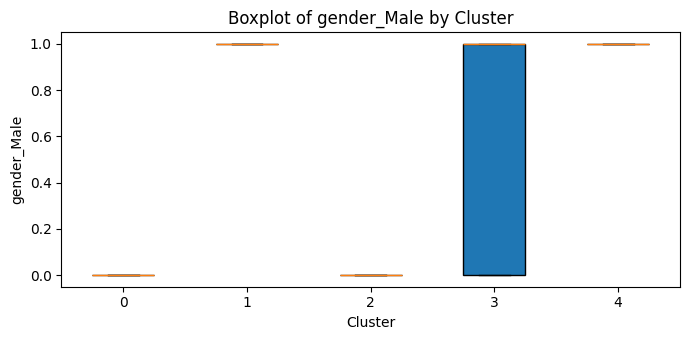

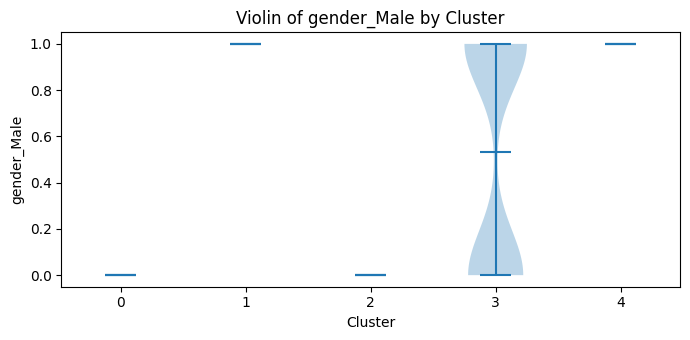

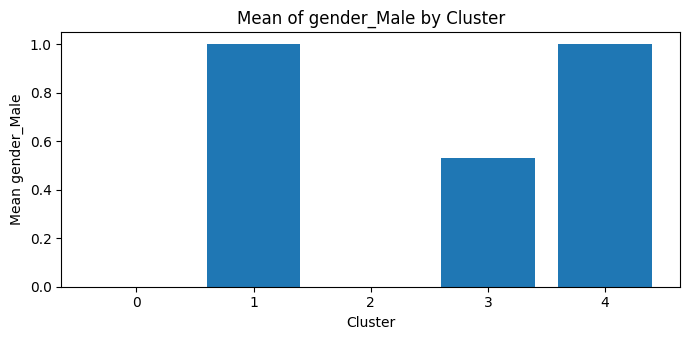

In [24]:

# 16.1) Cluster Characteristic Visualization — Practice

FEATURES_TO_PLOT = FEATURES  # consider a subset for speed

for col in FEATURES_TO_PLOT:
    if col not in work.columns: 
        continue
    # Boxplot by cluster
    plt.figure(figsize=(7,3.5))
    data = [work.loc[work["cluster"] == k, col].dropna().values for k in sorted(work["cluster"].unique())]
    plt.boxplot(data, labels=sorted(work["cluster"].unique()), patch_artist=True)
    plt.title(f"Boxplot of {col} by Cluster")
    plt.xlabel("Cluster"); plt.ylabel(col)
    plt.tight_layout(); plt.show()

    # Violin plot by cluster
    plt.figure(figsize=(7,3.5))
    plt.violinplot(dataset=data, showmeans=True, showmedians=False, showextrema=True)
    plt.title(f"Violin of {col} by Cluster")
    plt.xlabel("Cluster"); plt.ylabel(col)
    plt.xticks(ticks=np.arange(1, len(data)+1), labels=sorted(work["cluster"].unique()))
    plt.tight_layout(); plt.show()

    # Per-feature mean bar chart by cluster
    plt.figure(figsize=(7,3.5))
    means = [np.mean(d) if len(d) else np.nan for d in data]
    plt.bar([str(k) for k in sorted(work["cluster"].unique())], means)
    plt.title(f"Mean of {col} by Cluster")
    plt.xlabel("Cluster"); plt.ylabel(f"Mean {col}")
    plt.tight_layout(); plt.show()



## 16.2) Cluster Naming (Business Interpretation)

Assign business-friendly names to clusters based on profiles. Example: *"High Income / Low Hours"*.


In [25]:

# 16.2) Cluster Naming — Practice

unique_clusters = sorted(work["cluster"].unique())
cluster_name_map = {int(k): f"Cluster {int(k)} — TODO name" for k in unique_clusters if k != -1}
if -1 in unique_clusters:
    cluster_name_map[-1] = "Noise / Outliers"

work["cluster_name"] = work["cluster"].map(cluster_name_map)
display(work[[ID_COL, "cluster", "cluster_name"]].head(10))
print("Edit 'cluster_name_map' above to finalize names.")


,professional_id,cluster,cluster_name
0,1,2,Cluster 2 — TODO name
1,2,3,Cluster 3 — TODO name
2,3,0,Cluster 0 — TODO name
3,4,3,Cluster 3 — TODO name
4,5,2,Cluster 2 — TODO name
5,6,0,Cluster 0 — TODO name
6,7,0,Cluster 0 — TODO name
7,8,1,Cluster 1 — TODO name
8,9,0,Cluster 0 — TODO name
9,10,3,Cluster 3 — TODO name


Edit 'cluster_name_map' above to finalize names.



## 17) Export Artifacts — Theory

Persist cluster assignments and run configuration for reproducibility.



# 17) Export Artifacts — Practice

EXPORT_DIR = "outputs"
os.makedirs(EXPORT_DIR, exist_ok=True)

labels_path = os.path.join(EXPORT_DIR, "provider_clusters.csv")
cfg_path = os.path.join(EXPORT_DIR, "run_config.json")

out = work[[ID_COL, "cluster", "cluster_name"]].copy() if "cluster_name" in work.columns else work[[ID_COL, "cluster"]].copy()
out.to_csv(labels_path, index=False)

scaler_name = type(globals().get("scaler", type("NA",(object,),{})()) ).__name__ if "scaler" in globals() else None

config = dict(
    use_mock=USE_MOCK,
    n_samples=N_SAMPLES,
    id_col=ID_COL,
    features=FEATURES,
    scaler=scaler_name,
    apply_pca=APPLY_PCA,
    pca_components=int(PCA_N_COMPONENTS),
    algo=ALGO,
    params=dict(
        k=globals().get("K"),
        gmm_components=globals().get("GMM_COMPONENTS"),
        gmm_cov=globals().get("GMM_COV_TYPE"),
        agglo_n=globals().get("AGGLO_N_CLUSTERS"),
        agglo_linkage=globals().get("AGGLO_LINKAGE"),
        dbscan_eps=globals().get("DBSCAN_EPS"),
        dbscan_min_samples=globals().get("DBSCAN_MIN_SAMPLES"),
        spectral_n=globals().get("SPECTRAL_N_CLUSTERS"),
        spectral_affinity=globals().get("SPECTRAL_AFFINITY"),
    ),
    random_state=RANDOM_STATE
)
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=2)

print("Saved:", labels_path)
print("Saved:", cfg_path)
